In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle
import keras.backend as K

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
n_train = len(X_train)
n_val = int(n_train*0.1)
ind = np.arange(n_train)
np.random.shuffle(ind)
X_val, y_val = X_train[ind[:n_val]], y_train[ind[:n_val]]
X_train, y_train = X_train[ind[n_val:]], y_train[ind[n_val:]]

data = (X_train[:, :, :, np.newaxis], y_train, 
        X_val[:, :, :, np.newaxis], y_val)

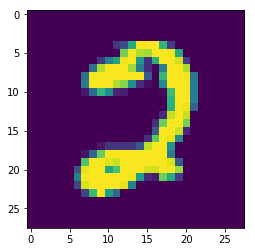

In [4]:
plt.imshow(X_train[0])

In [5]:
from cleverhans.utils import set_log_level
import logging

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

---
# V1

In [6]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v1", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v1.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [7]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [8]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.989, 0.028349320262670518)

In [10]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:697: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-19 00:10:15,181 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.957, 0.11421337127685546)
5.482497
(0.95, 0.10869316661357879)
5.483473
(0.945, 0.12141454946994781)
5.4799476
(0.948, 0.12445347285270691)
5.4824796
(0.956, 0.11174944496154784)
5.483405
(0.945, 0.11767887580394745)
5.485712
(0.95, 0.11284514224529266)
5.4778075
(0.954, 0.11603326970338822)
5.4814057
(0.95, 0.11805784273147583)
5.479167
(0.953, 0.11737936317920684)
5.4756255
0.987
5.326800787944078


In [23]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.8,
              'eps_iter': 0.001,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 500,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:697: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-19 00:25:40,352 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.0, 22.708133346557617)
10.624618
(0.006, 22.502650680541993)
10.619963
(0.002, 22.6405749206543)
10.615663
(0.003, 22.684357620239258)
10.609908
(0.003, 22.68256953430176)
10.623406
(0.003, 22.48466731262207)
10.622625


KeyboardInterrupt: 

In [11]:
pred = hingenet.predict_model(sess, adv)
y_pred = np.argmax(pred, axis=1)

In [10]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-16 05:34:45,977 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-16 05:34:46,225 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-16 05:34:46,333 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-16 05:34:46,584 cleverhans]     Iteration 0 of 200: loss=1.23e+04 l2=0
[DEBUG 2018-10-16 05:34:47,306 cleverhans]     Iteration 20 of 200: loss=2.36e+03 l2=23.4
[DEBUG 2018-10-16 05:34:47,848 cleverhans]     Iteration 40 of 200: loss=481 l2=42.4
[DEBUG 2018-10-16 05:34:48,266 cleverhans]     Iteration 60 of 200: loss=85.4 l2=44.8
[DEBUG 2018-10-16 05:34:48,643 cleverhans]     Iteration 80 of 200: loss=47.1 l2=47.1
[DEBUG 2018-10-16 05:34:49,014 cleverhans]     Iteration 100 of 200: loss=46.5 l2=46.5
[DEBUG 2018-10-16 05:34:49,386 cleverhans]     Iteration 120 of 200: loss=45.6 l2=45.6
[DEBUG 2018-10-16 05:34:49,768 cleverhans]     Iteration 140 of 200: loss=44.7 l2=44.7
[DEBUG 2018-10-16 05:34:50,149 cleverhans]     Iteration 1

6
[-215.11743164 -265.35617065 -111.46983337 -121.03096771  -62.38174057
  -54.80757904  123.41521454   41.12646866   48.99925995  -38.41850662]


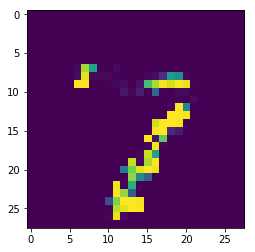

9
[-3.92608673e+02  3.40018094e-01  1.53681908e+01  2.28149166e+01
 -2.89193085e+02  1.04625984e+02 -1.98366211e+02 -2.41317978e+02
 -6.42337952e+01  1.69125244e+02]


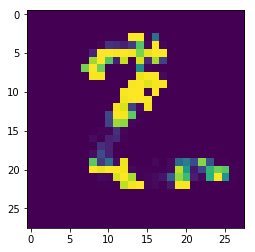

3
[-100.78073883   29.01500511  -53.6879158   108.46086884 -206.11326599
   41.75799561  -83.14700317 -142.70774841   49.76131439 -158.0584259 ]


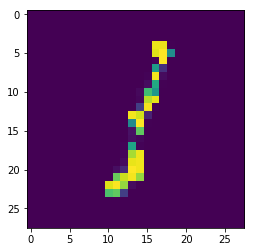

3
[ 114.81016541  -34.96350861  -48.57882309  124.12236023 -190.5398407
  -23.27542114 -215.07452393 -314.51568604 -160.79127502 -171.73678589]


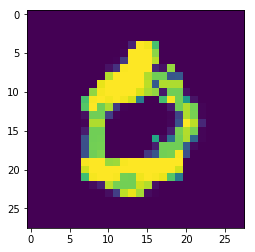

5
[-321.67196655 -305.77853394 -205.14918518  -52.73311234  192.03013611
  279.80813599 -222.45675659 -179.61206055 -159.56758118  192.04524231]


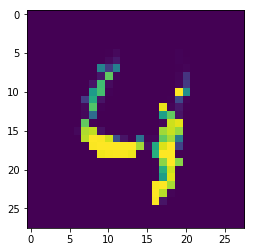

3
[-102.2842865  -113.25110626 -155.75691223  120.38713837 -135.65904236
  -71.92460632 -129.2686615  -141.2973938   112.18322754 -119.01683807]


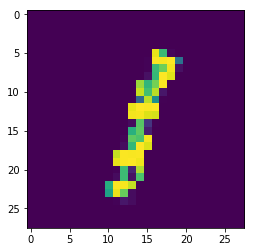

0
[  31.37387466 -262.10192871   -8.27180481 -400.39938354 -110.0223465
  -17.28675842  -12.40871906   26.04298019   28.45282745 -136.04486084]


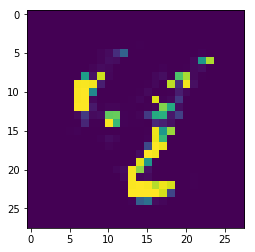

6
[-312.11984253 -238.70924377 -306.10675049  -28.58062553   78.86571503
   92.59507751  143.67205811 -124.98310852   35.78363037  -44.41374969]


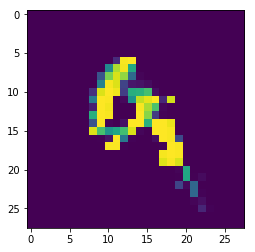

1
[-251.53407288  167.74943542   97.86354065  -69.05342102 -239.56838989
   83.08219147  143.41917419 -271.76916504  104.29174042 -544.31787109]


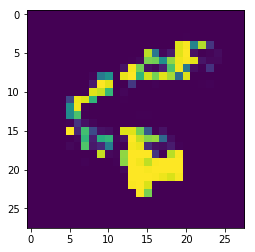

1
[-283.36218262  174.83467102 -109.40499115  -56.9993782   150.73271179
 -322.71127319 -498.37771606  163.61070251 -100.90690613 -191.13433838]


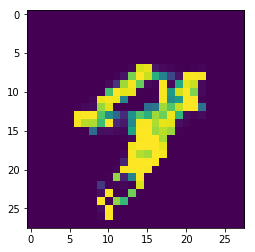

In [15]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

---
# V2

In [28]:
from hinge_net import HingeNet

# v2: margin = 1e5
hingenet = HingeNet("hingenet_v1", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v2.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 100000.0625
STEP: 50 	Loss: 99989.0938
STEP: 100 	Loss: 99105.3281
STEP: 150 	Loss: 82327.5078
STEP: 200 	Loss: 61771.8945
STEP: 250 	Loss: 55301.0547
STEP: 300 	Loss: 42422.2266
STEP: 350 	Loss: 29695.1250
STEP: 400 	Loss: 35694.9609
Train Acc|Loss:	0.8906|30157.2864
Val Acc|Loss:	0.8880|30367.8054
============= EPOCH: 1 =============
STEP: 0 	Loss: 25135.0078
STEP: 50 	Loss: 29948.3086
STEP: 100 	Loss: 31386.1426
STEP: 150 	Loss: 38046.3594
STEP: 200 	Loss: 22995.5449
STEP: 250 	Loss: 16748.4082
STEP: 300 	Loss: 18334.2773
STEP: 350 	Loss: 28994.3105
STEP: 400 	Loss: 20036.3418
Train Acc|Loss:	0.9155|22599.2633
Val Acc|Loss:	0.9177|22531.3663
============= EPOCH: 2 =============
STEP: 0 	Loss: 17342.5488
STEP: 50 	Loss: 21186.8887
STEP: 100 	Loss: 17605.2031
STEP: 150 	Loss: 20344.1172
STEP: 200 	Loss: 19530.2832
STEP: 250 	Loss: 23881.6211
STEP: 300 	Loss: 23397.3633
STEP: 350 	Loss: 15924.4482
STEP: 400 	Loss: 15912.5488
Train Acc

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [29]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.959, 9940.42390625)

In [30]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-16 05:52:49,017 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-16 05:52:49,489 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-16 05:52:49,625 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-16 05:52:49,842 cleverhans]     Iteration 0 of 200: loss=7.39e+06 l2=0
[DEBUG 2018-10-16 05:52:49,843 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-16 05:52:49,855 cleverhans]   Successfully generated adversarial examples on 0 of 1000 instances.
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[DEBUG 2018-10-16 05:52:49,862 cleverhans]    Mean successful distortion: nan
[DEBUG 2018-10-16 05:52:49,863 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-16 05:52:49,88

In [33]:
attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 1,
             'batch_size': n_attack,
             'initial_const': 1000,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-16 05:53:47,825 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-16 05:53:48,187 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-16 05:53:48,312 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-16 05:53:48,526 cleverhans]     Iteration 0 of 200: loss=7.39e+08 l2=0
[DEBUG 2018-10-16 05:53:48,527 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-16 05:53:48,539 cleverhans]   Successfully generated adversarial examples on 0 of 1000 instances.
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[DEBUG 2018-10-16 05:53:48,540 cleverhans]    Mean successful distortion: nan
[DEBUG 2018-10-16 05:53:48,541 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-16 05:53:48,55

In [ ]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

---
# V3

In [34]:
from hinge_net import HingeNet

# v3: margin = 1e4
hingenet = HingeNet("hingenet_v3", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v3.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

Saved weights not found...
Model was built, but no weight was loaded
============= EPOCH: 0 =============
STEP: 0 	Loss: 10000.0977
STEP: 50 	Loss: 9983.5527
STEP: 100 	Loss: 8938.8223
STEP: 150 	Loss: 4782.6201
STEP: 200 	Loss: 3860.2915
STEP: 250 	Loss: 2594.3945
STEP: 300 	Loss: 2514.8696
STEP: 350 	Loss: 2839.4934
STEP: 400 	Loss: 2107.4888
Train Acc|Loss:	0.9105|2402.5556
Val Acc|Loss:	0.9133|2400.3093
============= EPOCH: 1 =============
STEP: 0 	Loss: 1960.7366
STEP: 50 	Loss: 2286.6726
STEP: 100 	Loss: 1954.8359
STEP: 150 	Loss: 3189.4824
STEP: 200 	Loss: 1941.7174
STEP: 250 	Loss: 1464.6769
STEP: 300 	Loss: 1359.4871
STEP: 350 	Loss: 1081.5049
STEP: 400 	Loss: 1567.3577
Train Acc|Loss:	0.9312|1828.9218
Val Acc|Loss:	0.9337|1816.9886
============= EPOCH: 2 =============
STEP: 0 	Loss: 1193.1588
STEP: 50 	Loss: 1198.3889
STEP: 100 	Loss: 2700.6396
STEP: 150 	Loss: 935.1437
STEP: 200 	Loss: 1880.7336
STEP: 250 	Loss: 1276.1821
STEP: 300 	Loss: 1839.6975
STEP: 350 	Loss: 1654.6216

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [35]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.98, 561.3365126953125)

In [36]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-16 05:56:09,202 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-16 05:56:09,599 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-16 05:56:09,731 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-16 05:56:09,951 cleverhans]     Iteration 0 of 200: loss=7.6e+05 l2=0
[DEBUG 2018-10-16 05:56:10,663 cleverhans]     Iteration 20 of 200: loss=1.47e+05 l2=22.4
[DEBUG 2018-10-16 05:56:11,197 cleverhans]     Iteration 40 of 200: loss=3.23e+04 l2=41.5
[DEBUG 2018-10-16 05:56:11,619 cleverhans]     Iteration 60 of 200: loss=368 l2=45.8
[DEBUG 2018-10-16 05:56:11,984 cleverhans]     Iteration 80 of 200: loss=50.2 l2=50.2
[DEBUG 2018-10-16 05:56:12,348 cleverhans]     Iteration 100 of 200: loss=50.7 l2=50.7
[DEBUG 2018-10-16 05:56:12,349 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-16 05:56:12,363 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-16 05:56:12,364

6
[ -6587.22460938  -2035.03710938   7366.30859375    614.4317627
 -19880.66992188   2448.77294922   7450.56005859  -5602.96777344
  -3385.07543945 -11868.98535156]


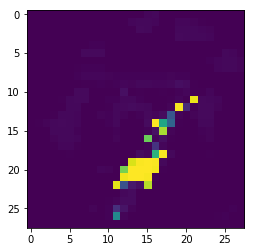

9
[ -9749.33886719  -8949.69335938   1239.3347168   11051.2578125
 -32374.68945312    992.86724854 -31398.           3907.27246094
  11712.109375    12434.24316406]


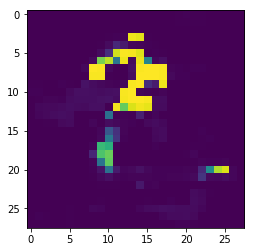

3
[-19136.42773438   8840.140625    -5828.48681641   9456.15039062
 -21556.24609375   1889.45959473 -10153.19433594 -11890.17480469
     28.47665024 -15965.91210938]


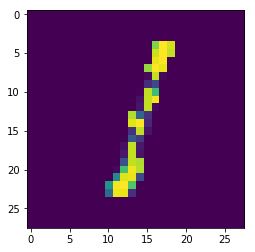

3
[ 11240.15429688    474.37579346    195.20846558  13818.046875
 -27245.6875       2198.19091797  -7684.94042969  -3959.85327148
 -13181.33398438 -19630.171875  ]


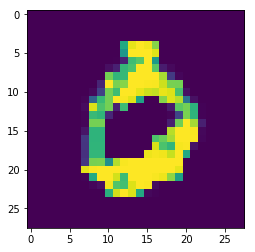

5
[-16538.02148438 -18953.00195312  -2702.69580078  -7358.34033203
   3081.83544922   4450.07910156  -8611.64550781  -3913.9140625
  -5508.21533203  -2875.55639648]


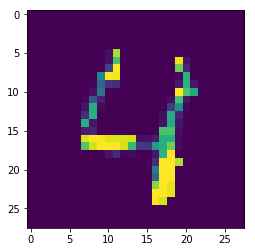

3
[-17905.22460938  10915.22851562 -15277.93359375  12232.28125
 -26803.0703125   -7058.28125    -33279.2109375   -3294.84570312
   4065.59619141  -5105.54443359]


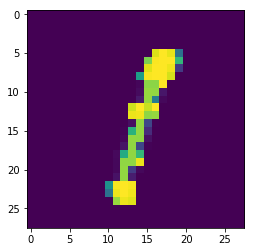

0
[  1414.7265625   -5633.62255859  -5493.30419922  -3951.75317383
 -16416.47265625  -6266.47949219 -15211.14160156    908.85021973
   -382.05703735  -3087.39624023]


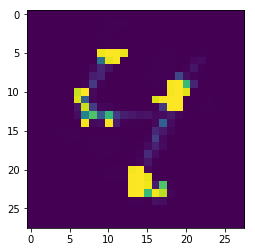

6
[-26899.73046875  -6605.98876953   6195.35302734  -6813.23193359
   4671.48193359   7886.88769531   7959.21826172 -32814.33984375
  -4317.06445312 -13628.62304688]


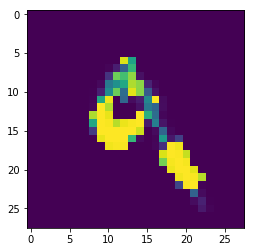

1
[-42620.76953125  10379.81542969   9390.90625    -19685.33007812
 -38035.09375      2465.8659668    2146.18164062 -26210.30664062
   2367.23779297 -39383.4609375 ]


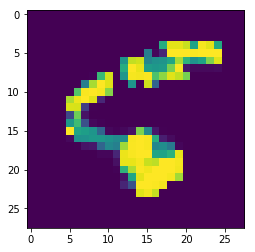

1
[ -5365.11523438   7724.80224609 -18706.21484375  -7489.34082031
 -11310.88476562 -24888.26953125  -9159.79980469   6627.82910156
   7112.49267578    946.81072998]


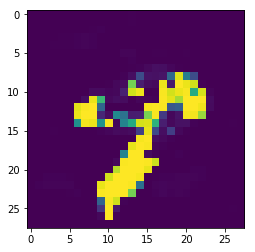

In [37]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

---
# V4

In [5]:
from hinge_net import HingeNet

# v4: margin = 1e4
hingenet = HingeNet("hingenet_v4", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v4.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [12]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [13]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.982, 542.6488989257813)

In [41]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-16 22:56:05,954 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-16 22:56:06,373 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-16 22:56:06,515 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-16 22:56:06,916 cleverhans]     Iteration 0 of 200: loss=9.56e+05 l2=0
[DEBUG 2018-10-16 22:56:08,131 cleverhans]     Iteration 20 of 200: loss=2.14e+05 l2=21.9
[DEBUG 2018-10-16 22:56:09,210 cleverhans]     Iteration 40 of 200: loss=4.5e+04 l2=40.1
[DEBUG 2018-10-16 22:56:10,138 cleverhans]     Iteration 60 of 200: loss=1.68e+03 l2=44.5
[DEBUG 2018-10-16 22:56:10,989 cleverhans]     Iteration 80 of 200: loss=53 l2=49
[DEBUG 2018-10-16 22:56:11,823 cleverhans]     Iteration 100 of 200: loss=49.5 l2=49.5
[DEBUG 2018-10-16 22:56:12,659 cleverhans]     Iteration 120 of 200: loss=49.5 l2=49.5
[DEBUG 2018-10-16 22:56:13,493 cleverhans]     Iteration 140 of 200: loss=49.4 l2=49.4
[DEBUG 2018-10-16 22:56:14,331 cleverhans]     Iterati

In [10]:
w = hingenet.model.get_weights()

print(np.sum(np.square(w[0])))
print(np.sum(np.square(w[2])))
print(np.sum(np.square(w[4])))
print(np.sum(np.square(w[6])))

34.77629
508.98956
220.14906
9414.516


---
# V5

In [18]:
from hinge_net import HingeNet

# v5: margin = 1e2 + reg 1e-2
hingenet = HingeNet("hingenet_v5", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v5.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 113.7146
STEP: 50 	Loss: 77.8226
STEP: 100 	Loss: 35.6897
STEP: 150 	Loss: 21.5876
STEP: 200 	Loss: 20.7295
STEP: 250 	Loss: 18.0567
STEP: 300 	Loss: 19.9233
STEP: 350 	Loss: 22.1151
STEP: 400 	Loss: 12.5048
Train Acc|Loss:	0.9699|14.4042
Val Acc|Loss:	0.9658|15.4017
============= EPOCH: 1 =============
STEP: 0 	Loss: 13.5842
STEP: 50 	Loss: 13.2340
STEP: 100 	Loss: 11.9854
STEP: 150 	Loss: 14.0580
STEP: 200 	Loss: 11.7501
STEP: 250 	Loss: 8.9481
STEP: 300 	Loss: 7.2810
STEP: 350 	Loss: 11.4658
STEP: 400 	Loss: 9.3650
Train Acc|Loss:	0.9774|12.0900
Val Acc|Loss:	0.9740|12.9774
============= EPOCH: 2 =============
STEP: 0 	Loss: 8.1658
STEP: 50 	Loss: 10.5882
STEP: 100 	Loss: 10.1512
STEP: 150 	Loss: 7.1672
STEP: 200 	Loss: 12.5345
STEP: 250 	Loss: 7.9408
STEP: 300 	Loss: 8.8523
STEP: 350 	Loss: 13.2235
STEP: 400 	Loss: 10.1158
Train Acc|Loss:	0.9839|9.9252
Val Acc|Loss:	0.9778|11.5846
============= EPOCH: 3 =============
STEP: 0 	Loss

In [19]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

15.06768
37.286293
36.279243
251.79393
47.63483
15.924272


In [20]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [21]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.984, 8.66723210144043)

In [22]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-17 06:33:25,662 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-17 06:33:26,016 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 06:33:26,035 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 06:33:26,143 cleverhans]     Iteration 0 of 200: loss=6.25e+03 l2=0
[DEBUG 2018-10-17 06:33:26,322 cleverhans]     Iteration 20 of 200: loss=1.52e+03 l2=21.1
[DEBUG 2018-10-17 06:33:26,483 cleverhans]     Iteration 40 of 200: loss=393 l2=38
[DEBUG 2018-10-17 06:33:26,619 cleverhans]     Iteration 60 of 200: loss=85.4 l2=41.5
[DEBUG 2018-10-17 06:33:26,729 cleverhans]     Iteration 80 of 200: loss=46.3 l2=43.6
[DEBUG 2018-10-17 06:33:26,844 cleverhans]     Iteration 100 of 200: loss=44.4 l2=42.7
[DEBUG 2018-10-17 06:33:26,948 cleverhans]     Iteration 120 of 200: loss=42.8 l2=41.6
[DEBUG 2018-10-17 06:33:27,059 cleverhans]     Iteration 140 of 200: loss=41.6 l2=40.5
[DEBUG 2018-10-17 06:33:27,184 cleverhans]     Iteration 160

[DEBUG 2018-10-17 06:33:35,788 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 06:33:35,795 cleverhans]     Iteration 0 of 200: loss=3.22e+03 l2=0
[DEBUG 2018-10-17 06:33:35,959 cleverhans]     Iteration 20 of 200: loss=699 l2=21.2
[DEBUG 2018-10-17 06:33:36,107 cleverhans]     Iteration 40 of 200: loss=190 l2=37.3
[DEBUG 2018-10-17 06:33:36,241 cleverhans]     Iteration 60 of 200: loss=63.6 l2=39.6
[DEBUG 2018-10-17 06:33:36,366 cleverhans]     Iteration 80 of 200: loss=44.4 l2=40.8
[DEBUG 2018-10-17 06:33:36,489 cleverhans]     Iteration 100 of 200: loss=39.4 l2=39.2
[DEBUG 2018-10-17 06:33:36,616 cleverhans]     Iteration 120 of 200: loss=37.4 l2=37.4
[DEBUG 2018-10-17 06:33:36,752 cleverhans]     Iteration 140 of 200: loss=35.8 l2=35.8
[DEBUG 2018-10-17 06:33:36,887 cleverhans]     Iteration 160 of 200: loss=34.4 l2=34.4
[DEBUG 2018-10-17 06:33:37,033 cleverhans]     Iteration 180 of 200: loss=33.2 l2=33.2
[DEBUG 2018-10-17 06:33:37,180 cleverhans]   Successfully generate

[DEBUG 2018-10-17 06:33:45,746 cleverhans]     Iteration 20 of 200: loss=412 l2=20.3
[DEBUG 2018-10-17 06:33:45,895 cleverhans]     Iteration 40 of 200: loss=163 l2=34.7
[DEBUG 2018-10-17 06:33:46,029 cleverhans]     Iteration 60 of 200: loss=74.1 l2=36.7
[DEBUG 2018-10-17 06:33:46,153 cleverhans]     Iteration 80 of 200: loss=42.8 l2=38.6
[DEBUG 2018-10-17 06:33:46,283 cleverhans]     Iteration 100 of 200: loss=37.1 l2=36.2
[DEBUG 2018-10-17 06:33:46,414 cleverhans]     Iteration 120 of 200: loss=33.9 l2=33.9
[DEBUG 2018-10-17 06:33:46,564 cleverhans]     Iteration 140 of 200: loss=31.9 l2=31.8
[DEBUG 2018-10-17 06:33:46,721 cleverhans]     Iteration 160 of 200: loss=30.1 l2=30.1
[DEBUG 2018-10-17 06:33:46,883 cleverhans]     Iteration 180 of 200: loss=28.8 l2=28.8
[DEBUG 2018-10-17 06:33:47,032 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:33:47,034 cleverhans]    Mean successful distortion: 5.1
[DEBUG 2018-10-17 06:33:47,035 

[DEBUG 2018-10-17 06:33:55,608 cleverhans]     Iteration 40 of 200: loss=466 l2=38.4
[DEBUG 2018-10-17 06:33:55,743 cleverhans]     Iteration 60 of 200: loss=114 l2=42
[DEBUG 2018-10-17 06:33:55,864 cleverhans]     Iteration 80 of 200: loss=52.1 l2=45.1
[DEBUG 2018-10-17 06:33:55,982 cleverhans]     Iteration 100 of 200: loss=44.8 l2=44.4
[DEBUG 2018-10-17 06:33:56,106 cleverhans]     Iteration 120 of 200: loss=43.2 l2=43.2
[DEBUG 2018-10-17 06:33:56,233 cleverhans]     Iteration 140 of 200: loss=42.1 l2=42.1
[DEBUG 2018-10-17 06:33:56,364 cleverhans]     Iteration 160 of 200: loss=41 l2=41
[DEBUG 2018-10-17 06:33:56,504 cleverhans]     Iteration 180 of 200: loss=39.9 l2=39.9
[DEBUG 2018-10-17 06:33:56,639 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:33:56,640 cleverhans]    Mean successful distortion: 5.818
[DEBUG 2018-10-17 06:33:56,642 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 06:33:56,650 cleverhans]     Ite

[DEBUG 2018-10-17 06:34:05,519 cleverhans]     Iteration 80 of 200: loss=43.1 l2=41.4
[DEBUG 2018-10-17 06:34:05,641 cleverhans]     Iteration 100 of 200: loss=40 l2=40
[DEBUG 2018-10-17 06:34:05,761 cleverhans]     Iteration 120 of 200: loss=38.6 l2=38.6
[DEBUG 2018-10-17 06:34:05,896 cleverhans]     Iteration 140 of 200: loss=37.1 l2=37.1
[DEBUG 2018-10-17 06:34:06,037 cleverhans]     Iteration 160 of 200: loss=35.8 l2=35.8
[DEBUG 2018-10-17 06:34:06,180 cleverhans]     Iteration 180 of 200: loss=34.6 l2=34.6
[DEBUG 2018-10-17 06:34:06,320 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:34:06,322 cleverhans]    Mean successful distortion: 5.594
[DEBUG 2018-10-17 06:34:06,323 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 06:34:06,331 cleverhans]     Iteration 0 of 200: loss=1.59e+03 l2=0
[DEBUG 2018-10-17 06:34:06,495 cleverhans]     Iteration 20 of 200: loss=380 l2=21
[DEBUG 2018-10-17 06:34:06,637 cleverhans]     It

In [23]:
hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1)))

(1.0, 83.54311163330078)

In [24]:
np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3))))

5.264866

## v5-1

In [6]:
from hinge_net import HingeNet

# v5-1: margin = 1e2 + reg 1e-1
hingenet = HingeNet("hingenet_v5-1", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v5-1.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 236.7465
STEP: 50 	Loss: 104.9080
STEP: 100 	Loss: 100.6855
STEP: 150 	Loss: 100.1609
STEP: 200 	Loss: 100.0541
STEP: 250 	Loss: 100.0187
STEP: 300 	Loss: 100.0059
STEP: 350 	Loss: 100.0023
STEP: 400 	Loss: 100.0010
Train Acc|Loss:	0.1125|100.0006
Val Acc|Loss:	0.1110|100.0006
============= EPOCH: 1 =============
STEP: 0 	Loss: 100.0005
STEP: 50 	Loss: 100.0004
STEP: 100 	Loss: 100.0005
STEP: 150 	Loss: 100.0004
STEP: 200 	Loss: 100.0006
STEP: 250 	Loss: 100.0006
STEP: 300 	Loss: 100.0005
STEP: 350 	Loss: 100.0004
STEP: 400 	Loss: 100.0005
Train Acc|Loss:	0.0972|100.0006
Val Acc|Loss:	0.0987|100.0006
============= EPOCH: 2 =============
STEP: 0 	Loss: 100.0006
STEP: 50 	Loss: 100.0005
STEP: 100 	Loss: 100.0005
STEP: 150 	Loss: 100.0005
STEP: 200 	Loss: 100.0006
STEP: 250 	Loss: 100.0004
STEP: 300 	Loss: 100.0004
STEP: 350 	Loss: 100.0005
STEP: 400 	Loss: 100.0006
Train Acc|Loss:	0.0972|100.0005
Val Acc|Loss:	0.0987|100.0005
==========

In [7]:
w = hingenet.model.get_weights()

print(np.sum(np.square(w[0])))
print(np.sum(np.square(w[2])))
print(np.sum(np.square(w[4])))
print(np.sum(np.square(w[6])))

7.7139174e-13
3.4556667e-08
2.186291e-07
0.0015364188


---

# V6

margin: 1e2, reg: 1e-2 only last layer

In [6]:
from hinge_net import HingeNet

# v6: margin = 1e2
hingenet = HingeNet("hingenet_v6", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v6.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 100.2293
STEP: 50 	Loss: 51.3560
STEP: 100 	Loss: 31.2097
STEP: 150 	Loss: 14.6339
STEP: 200 	Loss: 19.1159
STEP: 250 	Loss: 12.8310
STEP: 300 	Loss: 18.8083
STEP: 350 	Loss: 19.4443
STEP: 400 	Loss: 11.0443
Train Acc|Loss:	0.9549|11.9846
Val Acc|Loss:	0.9530|12.4999
============= EPOCH: 1 =============
STEP: 0 	Loss: 6.4233
STEP: 50 	Loss: 20.5357
STEP: 100 	Loss: 9.8066
STEP: 150 	Loss: 6.5252
STEP: 200 	Loss: 5.1022
STEP: 250 	Loss: 16.9937
STEP: 300 	Loss: 7.1036
STEP: 350 	Loss: 4.9395
STEP: 400 	Loss: 3.5639
Train Acc|Loss:	0.9753|6.6947
Val Acc|Loss:	0.9723|8.0704
============= EPOCH: 2 =============
STEP: 0 	Loss: 7.4726
STEP: 50 	Loss: 2.0156
STEP: 100 	Loss: 7.8608
STEP: 150 	Loss: 4.9554
STEP: 200 	Loss: 6.7891
STEP: 250 	Loss: 4.7532
STEP: 300 	Loss: 8.0770
STEP: 350 	Loss: 5.5671
STEP: 400 	Loss: 2.8118
Train Acc|Loss:	0.9818|5.0860
Val Acc|Loss:	0.9750|6.5758
============= EPOCH: 3 =============
STEP: 0 	Loss: 2.6055
STE

In [13]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

10.762536
213.58672
134.30278
3195.0618
308.37683
12.999322


In [9]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-17 06:12:29,395 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.988, 3.460313545227051)


[DEBUG 2018-10-17 06:12:29,657 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 06:12:29,682 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 06:12:29,839 cleverhans]     Iteration 0 of 200: loss=1.14e+04 l2=0
[DEBUG 2018-10-17 06:12:30,023 cleverhans]     Iteration 20 of 200: loss=2.89e+03 l2=21.3
[DEBUG 2018-10-17 06:12:30,180 cleverhans]     Iteration 40 of 200: loss=600 l2=41
[DEBUG 2018-10-17 06:12:30,311 cleverhans]     Iteration 60 of 200: loss=123 l2=44.5
[DEBUG 2018-10-17 06:12:30,431 cleverhans]     Iteration 80 of 200: loss=46.9 l2=46.7
[DEBUG 2018-10-17 06:12:30,540 cleverhans]     Iteration 100 of 200: loss=46.1 l2=46.1
[DEBUG 2018-10-17 06:12:30,642 cleverhans]     Iteration 120 of 200: loss=45.4 l2=45.4
[DEBUG 2018-10-17 06:12:30,755 cleverhans]     Iteration 140 of 200: loss=44.7 l2=44.7
[DEBUG 2018-10-17 06:12:30,873 cleverhans]     Iteration 160 of 200: loss=44 l2=44
[DEBUG 2018-10-17 06:12:30,994 cleverhans]     Iteration 180 of 200: l

[DEBUG 2018-10-17 06:12:39,155 cleverhans]     Iteration 0 of 200: loss=5.49e+03 l2=0
[DEBUG 2018-10-17 06:12:39,316 cleverhans]     Iteration 20 of 200: loss=1.31e+03 l2=21.2
[DEBUG 2018-10-17 06:12:39,460 cleverhans]     Iteration 40 of 200: loss=296 l2=39.7
[DEBUG 2018-10-17 06:12:39,586 cleverhans]     Iteration 60 of 200: loss=77.2 l2=42.7
[DEBUG 2018-10-17 06:12:39,707 cleverhans]     Iteration 80 of 200: loss=45.8 l2=44.7
[DEBUG 2018-10-17 06:12:39,823 cleverhans]     Iteration 100 of 200: loss=43.6 l2=43.6
[DEBUG 2018-10-17 06:12:39,945 cleverhans]     Iteration 120 of 200: loss=42.2 l2=42.2
[DEBUG 2018-10-17 06:12:40,071 cleverhans]     Iteration 140 of 200: loss=41 l2=41
[DEBUG 2018-10-17 06:12:40,202 cleverhans]     Iteration 160 of 200: loss=39.9 l2=39.9
[DEBUG 2018-10-17 06:12:40,338 cleverhans]     Iteration 180 of 200: loss=38.9 l2=38.9
[DEBUG 2018-10-17 06:12:40,473 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:1

[DEBUG 2018-10-17 06:12:48,735 cleverhans]     Iteration 40 of 200: loss=274 l2=37.5
[DEBUG 2018-10-17 06:12:48,869 cleverhans]     Iteration 60 of 200: loss=75.1 l2=40.5
[DEBUG 2018-10-17 06:12:48,996 cleverhans]     Iteration 80 of 200: loss=45 l2=43.8
[DEBUG 2018-10-17 06:12:49,119 cleverhans]     Iteration 100 of 200: loss=41.8 l2=41.8
[DEBUG 2018-10-17 06:12:49,249 cleverhans]     Iteration 120 of 200: loss=39.7 l2=39.7
[DEBUG 2018-10-17 06:12:49,388 cleverhans]     Iteration 140 of 200: loss=37.9 l2=37.8
[DEBUG 2018-10-17 06:12:49,517 cleverhans]     Iteration 160 of 200: loss=36.2 l2=36.2
[DEBUG 2018-10-17 06:12:49,658 cleverhans]     Iteration 180 of 200: loss=34.8 l2=34.8
[DEBUG 2018-10-17 06:12:49,806 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:12:49,808 cleverhans]    Mean successful distortion: 5.59
[DEBUG 2018-10-17 06:12:49,808 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-17 06:12:49,813

[DEBUG 2018-10-17 06:12:58,280 cleverhans]     Iteration 60 of 200: loss=122 l2=44.5
[DEBUG 2018-10-17 06:12:58,400 cleverhans]     Iteration 80 of 200: loss=48 l2=48
[DEBUG 2018-10-17 06:12:58,521 cleverhans]     Iteration 100 of 200: loss=47.5 l2=47.5
[DEBUG 2018-10-17 06:12:58,642 cleverhans]     Iteration 120 of 200: loss=46.5 l2=46.5
[DEBUG 2018-10-17 06:12:58,763 cleverhans]     Iteration 140 of 200: loss=45.6 l2=45.6
[DEBUG 2018-10-17 06:12:58,881 cleverhans]     Iteration 160 of 200: loss=44.8 l2=44.8
[DEBUG 2018-10-17 06:12:59,002 cleverhans]     Iteration 180 of 200: loss=44 l2=44
[DEBUG 2018-10-17 06:12:59,126 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:12:59,127 cleverhans]    Mean successful distortion: 5.946
[DEBUG 2018-10-17 06:12:59,129 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 06:12:59,138 cleverhans]     Iteration 0 of 200: loss=5.79e+03 l2=0
[DEBUG 2018-10-17 06:12:59,306 cleverhans]     Iter

[DEBUG 2018-10-17 06:13:07,905 cleverhans]     Iteration 100 of 200: loss=46.2 l2=44.5
[DEBUG 2018-10-17 06:13:08,027 cleverhans]     Iteration 120 of 200: loss=44.6 l2=43.3
[DEBUG 2018-10-17 06:13:08,149 cleverhans]     Iteration 140 of 200: loss=43.2 l2=42.2
[DEBUG 2018-10-17 06:13:08,274 cleverhans]     Iteration 160 of 200: loss=41.2 l2=41.2
[DEBUG 2018-10-17 06:13:08,408 cleverhans]     Iteration 180 of 200: loss=40.2 l2=40.2
[DEBUG 2018-10-17 06:13:08,526 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:13:08,527 cleverhans]    Mean successful distortion: 5.886
[DEBUG 2018-10-17 06:13:08,528 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 06:13:08,535 cleverhans]     Iteration 0 of 200: loss=2.89e+03 l2=0
[DEBUG 2018-10-17 06:13:08,694 cleverhans]     Iteration 20 of 200: loss=707 l2=21.5
[DEBUG 2018-10-17 06:13:08,840 cleverhans]     Iteration 40 of 200: loss=181 l2=40.2
[DEBUG 2018-10-17 06:13:08,972 cleverhans]  

In [10]:
print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

(1.0, 72.54014556884766)
5.7469506


## V6-1

In [14]:
from hinge_net import HingeNet

# v6: margin = 1e2
hingenet = HingeNet("hingenet_v6-1", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v6-1.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

Saved weights not found...
Model was built, but no weight was loaded
============= EPOCH: 0 =============
STEP: 0 	Loss: 101.9501
STEP: 50 	Loss: 96.1238
STEP: 100 	Loss: 29.2052
STEP: 150 	Loss: 20.1713
STEP: 200 	Loss: 17.2848
STEP: 250 	Loss: 6.7504
STEP: 300 	Loss: 8.7425
STEP: 350 	Loss: 4.2459
STEP: 400 	Loss: 5.4944
Train Acc|Loss:	0.9650|10.0032
Val Acc|Loss:	0.9618|11.2933
============= EPOCH: 1 =============
STEP: 0 	Loss: 9.7692
STEP: 50 	Loss: 12.6963
STEP: 100 	Loss: 4.5216
STEP: 150 	Loss: 6.0690
STEP: 200 	Loss: 8.1950
STEP: 250 	Loss: 15.9693
STEP: 300 	Loss: 4.4958
STEP: 350 	Loss: 8.0432
STEP: 400 	Loss: 8.9655
Train Acc|Loss:	0.9825|5.2987
Val Acc|Loss:	0.9772|6.5333
============= EPOCH: 2 =============
STEP: 0 	Loss: 7.8534
STEP: 50 	Loss: 7.7250
STEP: 100 	Loss: 3.1878
STEP: 150 	Loss: 8.5066
STEP: 200 	Loss: 7.9395
STEP: 250 	Loss: 6.9713
STEP: 300 	Loss: 3.5759
STEP: 350 	Loss: 7.4707
STEP: 400 	Loss: 5.3065
Train Acc|Loss:	0.9859|4.3561
Val Acc|Loss:	0.9790|6.11

In [15]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

9.065339
159.00168
114.68034
2874.5845
250.53368
4.2375097


In [16]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

[INFO 2018-10-17 06:46:35,365 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.986, 4.156349124908448)


[DEBUG 2018-10-17 06:46:36,079 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 06:46:36,102 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 06:46:36,495 cleverhans]     Iteration 0 of 200: loss=7.7e+03 l2=0
[DEBUG 2018-10-17 06:46:36,675 cleverhans]     Iteration 20 of 200: loss=1.7e+03 l2=20.8
[DEBUG 2018-10-17 06:46:36,837 cleverhans]     Iteration 40 of 200: loss=403 l2=38.2
[DEBUG 2018-10-17 06:46:36,970 cleverhans]     Iteration 60 of 200: loss=77.8 l2=41.6
[DEBUG 2018-10-17 06:46:37,090 cleverhans]     Iteration 80 of 200: loss=46.9 l2=43.9
[DEBUG 2018-10-17 06:46:37,204 cleverhans]     Iteration 100 of 200: loss=43.9 l2=42.9
[DEBUG 2018-10-17 06:46:37,316 cleverhans]     Iteration 120 of 200: loss=41.8 l2=41.8
[DEBUG 2018-10-17 06:46:37,435 cleverhans]     Iteration 140 of 200: loss=40.7 l2=40.7
[DEBUG 2018-10-17 06:46:37,559 cleverhans]     Iteration 160 of 200: loss=39.7 l2=39.7
[DEBUG 2018-10-17 06:46:37,687 cleverhans]     Iteration 180 of 2

[DEBUG 2018-10-17 06:46:45,890 cleverhans]     Iteration 0 of 200: loss=3.83e+03 l2=0
[DEBUG 2018-10-17 06:46:46,059 cleverhans]     Iteration 20 of 200: loss=819 l2=20.9
[DEBUG 2018-10-17 06:46:46,205 cleverhans]     Iteration 40 of 200: loss=211 l2=36.9
[DEBUG 2018-10-17 06:46:46,335 cleverhans]     Iteration 60 of 200: loss=48.8 l2=39.3
[DEBUG 2018-10-17 06:46:46,454 cleverhans]     Iteration 80 of 200: loss=40.4 l2=40.4
[DEBUG 2018-10-17 06:46:46,576 cleverhans]     Iteration 100 of 200: loss=38.5 l2=38.5
[DEBUG 2018-10-17 06:46:46,703 cleverhans]     Iteration 120 of 200: loss=36.9 l2=36.9
[DEBUG 2018-10-17 06:46:46,835 cleverhans]     Iteration 140 of 200: loss=35.5 l2=35.5
[DEBUG 2018-10-17 06:46:46,970 cleverhans]     Iteration 160 of 200: loss=34.2 l2=34.2
[DEBUG 2018-10-17 06:46:47,109 cleverhans]     Iteration 180 of 200: loss=33.1 l2=33.1
[DEBUG 2018-10-17 06:46:47,253 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:46

[DEBUG 2018-10-17 06:46:55,604 cleverhans]     Iteration 40 of 200: loss=210 l2=35.3
[DEBUG 2018-10-17 06:46:55,731 cleverhans]     Iteration 60 of 200: loss=68.2 l2=37.9
[DEBUG 2018-10-17 06:46:55,857 cleverhans]     Iteration 80 of 200: loss=41.4 l2=40.7
[DEBUG 2018-10-17 06:46:55,983 cleverhans]     Iteration 100 of 200: loss=38 l2=38
[DEBUG 2018-10-17 06:46:56,111 cleverhans]     Iteration 120 of 200: loss=35.5 l2=35.5
[DEBUG 2018-10-17 06:46:56,256 cleverhans]     Iteration 140 of 200: loss=33.4 l2=33.4
[DEBUG 2018-10-17 06:46:56,405 cleverhans]     Iteration 160 of 200: loss=31.7 l2=31.7
[DEBUG 2018-10-17 06:46:56,554 cleverhans]     Iteration 180 of 200: loss=30.3 l2=30.2
[DEBUG 2018-10-17 06:46:56,702 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:46:56,703 cleverhans]    Mean successful distortion: 5.211
[DEBUG 2018-10-17 06:46:56,704 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-17 06:46:56,710 

[DEBUG 2018-10-17 06:47:05,344 cleverhans]     Iteration 60 of 200: loss=86.8 l2=40.9
[DEBUG 2018-10-17 06:47:05,460 cleverhans]     Iteration 80 of 200: loss=44.8 l2=44.8
[DEBUG 2018-10-17 06:47:05,575 cleverhans]     Iteration 100 of 200: loss=43.8 l2=43.8
[DEBUG 2018-10-17 06:47:05,691 cleverhans]     Iteration 120 of 200: loss=42.4 l2=42.4
[DEBUG 2018-10-17 06:47:05,812 cleverhans]     Iteration 140 of 200: loss=41.1 l2=41.1
[DEBUG 2018-10-17 06:47:05,933 cleverhans]     Iteration 160 of 200: loss=40.1 l2=40.1
[DEBUG 2018-10-17 06:47:06,060 cleverhans]     Iteration 180 of 200: loss=39 l2=39
[DEBUG 2018-10-17 06:47:06,172 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:47:06,173 cleverhans]    Mean successful distortion: 5.7
[DEBUG 2018-10-17 06:47:06,175 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 06:47:06,182 cleverhans]     Iteration 0 of 200: loss=3.75e+03 l2=0
[DEBUG 2018-10-17 06:47:06,347 cleverhans]     I

[DEBUG 2018-10-17 06:47:15,083 cleverhans]     Iteration 100 of 200: loss=41 l2=41
[DEBUG 2018-10-17 06:47:15,193 cleverhans]     Iteration 120 of 200: loss=39.4 l2=39.4
[DEBUG 2018-10-17 06:47:15,320 cleverhans]     Iteration 140 of 200: loss=38 l2=38
[DEBUG 2018-10-17 06:47:15,458 cleverhans]     Iteration 160 of 200: loss=36.7 l2=36.7
[DEBUG 2018-10-17 06:47:15,602 cleverhans]     Iteration 180 of 200: loss=35.5 l2=35.5
[DEBUG 2018-10-17 06:47:15,749 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 06:47:15,750 cleverhans]    Mean successful distortion: 5.598
[DEBUG 2018-10-17 06:47:15,752 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 06:47:15,760 cleverhans]     Iteration 0 of 200: loss=1.96e+03 l2=0
[DEBUG 2018-10-17 06:47:15,925 cleverhans]     Iteration 20 of 200: loss=480 l2=20.9
[DEBUG 2018-10-17 06:47:16,074 cleverhans]     Iteration 40 of 200: loss=131 l2=37.4
[DEBUG 2018-10-17 06:47:16,207 cleverhans]     Itera

(1.0, 74.75543774414062)
5.3261156


---

# V7

margin: 1, last layer is sigmoid

In [6]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v7", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v7.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 1.0152
STEP: 50 	Loss: 0.2193
STEP: 100 	Loss: 0.1139
STEP: 150 	Loss: 0.1063
STEP: 200 	Loss: 0.0759
STEP: 250 	Loss: 0.0999
STEP: 300 	Loss: 0.0501
STEP: 350 	Loss: 0.0423
STEP: 400 	Loss: 0.0451
Train Acc|Loss:	0.9744|0.0567
Val Acc|Loss:	0.9720|0.0602
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.0905
STEP: 50 	Loss: 0.1091
STEP: 100 	Loss: 0.0871
STEP: 150 	Loss: 0.0132
STEP: 200 	Loss: 0.0693
STEP: 250 	Loss: 0.0380
STEP: 300 	Loss: 0.0208
STEP: 350 	Loss: 0.0518
STEP: 400 	Loss: 0.0501
Train Acc|Loss:	0.9782|0.0468
Val Acc|Loss:	0.9730|0.0566
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0297
STEP: 50 	Loss: 0.0484
STEP: 100 	Loss: 0.0316
STEP: 150 	Loss: 0.0853
STEP: 200 	Loss: 0.0264
STEP: 250 	Loss: 0.0600
STEP: 300 	Loss: 0.0365
STEP: 350 	Loss: 0.0480
STEP: 400 	Loss: 0.0262
Train Acc|Loss:	0.9809|0.0403
Val Acc|Loss:	0.9770|0.0507
============= EPOCH: 3 =============
STEP: 0 	Loss: 0.0220
STEP: 50 	Loss: 0

In [7]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

7.541233
129.41727
169.06192
9439.0625
290.21494
22.384285


In [8]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

[INFO 2018-10-17 06:57:23,202 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.984, 0.03265167073532939)


[DEBUG 2018-10-17 06:57:23,454 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 06:57:23,478 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 06:57:23,606 cleverhans]     Iteration 0 of 200: loss=10 l2=0
[DEBUG 2018-10-17 06:57:23,785 cleverhans]     Iteration 20 of 200: loss=9.81 l2=0.0126
[DEBUG 2018-10-17 06:57:23,945 cleverhans]     Iteration 40 of 200: loss=9.8 l2=0.00302
[DEBUG 2018-10-17 06:57:24,106 cleverhans]     Iteration 60 of 200: loss=9.8 l2=0.00223
[DEBUG 2018-10-17 06:57:24,275 cleverhans]     Iteration 80 of 200: loss=9.8 l2=0.00178
[DEBUG 2018-10-17 06:57:24,276 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-17 06:57:24,278 cleverhans]   Successfully generated adversarial examples on 0 of 100 instances.
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invali

[DEBUG 2018-10-17 06:57:30,005 cleverhans]     Iteration 80 of 200: loss=97 l2=0.014
[DEBUG 2018-10-17 06:57:30,006 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-17 06:57:30,009 cleverhans]   Successfully generated adversarial examples on 0 of 100 instances.
[DEBUG 2018-10-17 06:57:30,010 cleverhans]    Mean successful distortion: nan
[DEBUG 2018-10-17 06:57:30,014 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 06:57:30,023 cleverhans]     Iteration 0 of 200: loss=990 l2=0
[DEBUG 2018-10-17 06:57:30,187 cleverhans]     Iteration 20 of 200: loss=970 l2=0.0543
[DEBUG 2018-10-17 06:57:30,344 cleverhans]     Iteration 40 of 200: loss=970 l2=0.0589
[DEBUG 2018-10-17 06:57:30,344 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-17 06:57:30,346 cleverhans]   Successfully generated adversarial examples on 0 of 100 instances.
[DEBUG 2018-10-17 06:57:30,347 cleverhans]    Mean successful distortion: nan
[DEBUG 2018-10-17 06:57:30,347 cleverhans] 

[DEBUG 2018-10-17 06:57:34,473 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-17 06:57:34,474 cleverhans]   Successfully generated adversarial examples on 0 of 100 instances.
[DEBUG 2018-10-17 06:57:34,475 cleverhans]    Mean successful distortion: nan
[DEBUG 2018-10-17 06:57:34,476 cleverhans] Running CWL2 attack on instance 800 of 1000
[DEBUG 2018-10-17 06:57:34,480 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 06:57:34,487 cleverhans]     Iteration 0 of 200: loss=9.9 l2=0
[DEBUG 2018-10-17 06:57:34,637 cleverhans]     Iteration 20 of 200: loss=9.81 l2=0.0141
[DEBUG 2018-10-17 06:57:34,797 cleverhans]     Iteration 40 of 200: loss=9.81 l2=0.00526
[DEBUG 2018-10-17 06:57:34,955 cleverhans]     Iteration 60 of 200: loss=9.8 l2=0.00224
[DEBUG 2018-10-17 06:57:35,121 cleverhans]     Iteration 80 of 200: loss=9.8 l2=0.0014
[DEBUG 2018-10-17 06:57:35,122 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-17 06:57:35,125 cleverhans]   Successf

(0.0, 1.9914679679870606)
0.0


### attack at layer before sigmoid

In [7]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v7", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v7.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [8]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

7.541233
129.41727
169.06192
9439.0625
290.21494
22.384285


In [10]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

[INFO 2018-10-17 08:36:36,342 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.984, 0.03265167073532939)


[DEBUG 2018-10-17 08:36:36,585 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 08:36:36,609 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 08:36:36,726 cleverhans]     Iteration 0 of 200: loss=2.94e+03 l2=0
[DEBUG 2018-10-17 08:36:36,902 cleverhans]     Iteration 20 of 200: loss=532 l2=20.3
[DEBUG 2018-10-17 08:36:37,070 cleverhans]     Iteration 40 of 200: loss=200 l2=33.3
[DEBUG 2018-10-17 08:36:37,223 cleverhans]     Iteration 60 of 200: loss=76 l2=35.4
[DEBUG 2018-10-17 08:36:37,373 cleverhans]     Iteration 80 of 200: loss=47.1 l2=37.5
[DEBUG 2018-10-17 08:36:37,506 cleverhans]     Iteration 100 of 200: loss=39.6 l2=36.5
[DEBUG 2018-10-17 08:36:37,633 cleverhans]     Iteration 120 of 200: loss=36.3 l2=34.9
[DEBUG 2018-10-17 08:36:37,778 cleverhans]     Iteration 140 of 200: loss=34.3 l2=33.4
[DEBUG 2018-10-17 08:36:37,933 cleverhans]     Iteration 160 of 200: loss=32.4 l2=32
[DEBUG 2018-10-17 08:36:38,084 cleverhans]     Iteration 180 of 200: los

[DEBUG 2018-10-17 08:36:47,342 cleverhans]     Iteration 0 of 200: loss=1.31e+03 l2=0
[DEBUG 2018-10-17 08:36:47,504 cleverhans]     Iteration 20 of 200: loss=253 l2=19.2
[DEBUG 2018-10-17 08:36:47,653 cleverhans]     Iteration 40 of 200: loss=103 l2=30.2
[DEBUG 2018-10-17 08:36:47,796 cleverhans]     Iteration 60 of 200: loss=54.3 l2=31.8
[DEBUG 2018-10-17 08:36:47,932 cleverhans]     Iteration 80 of 200: loss=38.4 l2=32.1
[DEBUG 2018-10-17 08:36:48,073 cleverhans]     Iteration 100 of 200: loss=33 l2=30.4
[DEBUG 2018-10-17 08:36:48,223 cleverhans]     Iteration 120 of 200: loss=29.9 l2=28.5
[DEBUG 2018-10-17 08:36:48,379 cleverhans]     Iteration 140 of 200: loss=27.4 l2=26.9
[DEBUG 2018-10-17 08:36:48,536 cleverhans]     Iteration 160 of 200: loss=25.7 l2=25.5
[DEBUG 2018-10-17 08:36:48,693 cleverhans]     Iteration 180 of 200: loss=24.1 l2=24
[DEBUG 2018-10-17 08:36:48,838 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 08:36:48,

[DEBUG 2018-10-17 08:36:58,119 cleverhans]     Iteration 40 of 200: loss=85.2 l2=27.6
[DEBUG 2018-10-17 08:36:58,258 cleverhans]     Iteration 60 of 200: loss=43.2 l2=28.1
[DEBUG 2018-10-17 08:36:58,399 cleverhans]     Iteration 80 of 200: loss=31.2 l2=28.1
[DEBUG 2018-10-17 08:36:58,537 cleverhans]     Iteration 100 of 200: loss=25.9 l2=24.9
[DEBUG 2018-10-17 08:36:58,677 cleverhans]     Iteration 120 of 200: loss=22.6 l2=22.2
[DEBUG 2018-10-17 08:36:58,826 cleverhans]     Iteration 140 of 200: loss=20.5 l2=20.2
[DEBUG 2018-10-17 08:36:58,973 cleverhans]     Iteration 160 of 200: loss=18.9 l2=18.8
[DEBUG 2018-10-17 08:36:59,118 cleverhans]     Iteration 180 of 200: loss=17.6 l2=17.3
[DEBUG 2018-10-17 08:36:59,253 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 08:36:59,254 cleverhans]    Mean successful distortion: 3.873
[DEBUG 2018-10-17 08:36:59,255 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-17 08:36:59

[DEBUG 2018-10-17 08:37:08,735 cleverhans]     Iteration 60 of 200: loss=86.3 l2=35.9
[DEBUG 2018-10-17 08:37:08,881 cleverhans]     Iteration 80 of 200: loss=51.9 l2=38.9
[DEBUG 2018-10-17 08:37:09,032 cleverhans]     Iteration 100 of 200: loss=43 l2=38.1
[DEBUG 2018-10-17 08:37:09,188 cleverhans]     Iteration 120 of 200: loss=37.9 l2=36.3
[DEBUG 2018-10-17 08:37:09,345 cleverhans]     Iteration 140 of 200: loss=35.2 l2=34.7
[DEBUG 2018-10-17 08:37:09,506 cleverhans]     Iteration 160 of 200: loss=33.6 l2=33.2
[DEBUG 2018-10-17 08:37:09,668 cleverhans]     Iteration 180 of 200: loss=32 l2=31.9
[DEBUG 2018-10-17 08:37:09,818 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 08:37:09,820 cleverhans]    Mean successful distortion: 5.327
[DEBUG 2018-10-17 08:37:09,821 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 08:37:09,831 cleverhans]     Iteration 0 of 200: loss=1.39e+03 l2=0
[DEBUG 2018-10-17 08:37:10,000 cleverhans]    

[DEBUG 2018-10-17 08:37:19,581 cleverhans]     Iteration 100 of 200: loss=33.7 l2=32.3
[DEBUG 2018-10-17 08:37:19,725 cleverhans]     Iteration 120 of 200: loss=31 l2=30.3
[DEBUG 2018-10-17 08:37:19,878 cleverhans]     Iteration 140 of 200: loss=29 l2=28.5
[DEBUG 2018-10-17 08:37:20,030 cleverhans]     Iteration 160 of 200: loss=27 l2=26.8
[DEBUG 2018-10-17 08:37:20,182 cleverhans]     Iteration 180 of 200: loss=25.6 l2=25.4
[DEBUG 2018-10-17 08:37:20,331 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 08:37:20,332 cleverhans]    Mean successful distortion: 4.742
[DEBUG 2018-10-17 08:37:20,334 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 08:37:20,342 cleverhans]     Iteration 0 of 200: loss=694 l2=0
[DEBUG 2018-10-17 08:37:20,502 cleverhans]     Iteration 20 of 200: loss=141 l2=19.2
[DEBUG 2018-10-17 08:37:20,652 cleverhans]     Iteration 40 of 200: loss=69.9 l2=29.5
[DEBUG 2018-10-17 08:37:20,797 cleverhans]     Iterati

(0.999, 0.8605294427871704)
4.1633554


0
[7.45361209e-01 4.57285836e-07 1.25984969e-02 2.01547323e-06
 8.99190322e-09 1.90393816e-08 1.46426009e-02 7.16205597e-01
 1.38652264e-04 3.58259875e-08]


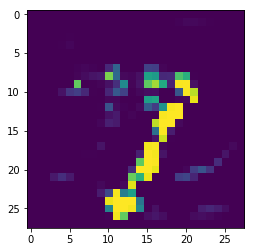

0
[9.99883771e-01 0.00000000e+00 9.98393953e-01 3.64071421e-36
 1.95681918e-33 0.00000000e+00 1.02564094e-12 0.00000000e+00
 1.51401429e-22 1.90015841e-30]


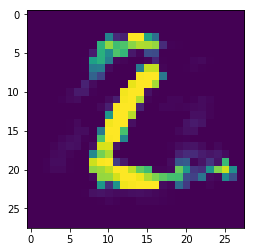

9
[8.64058791e-07 1.11547217e-03 2.80430261e-03 7.22162383e-07
 2.34114399e-04 2.84012674e-10 8.83982807e-08 5.55499780e-09
 4.12542477e-06 6.54162886e-03]


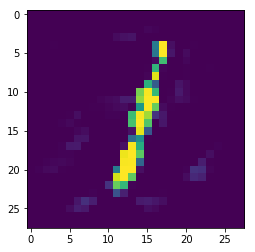

1
[1.32837286e-07 7.67907593e-04 1.34100092e-05 4.83378535e-05
 1.02495649e-12 1.16256729e-08 1.45759842e-13 3.07949705e-07
 2.11993682e-12 1.16535341e-08]


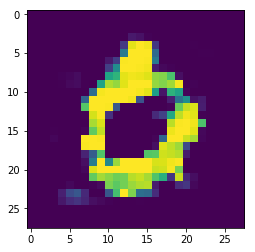

0
[3.76847275e-02 1.82149709e-08 2.70322454e-03 2.91073602e-03
 1.83509465e-03 3.71342776e-06 1.41759665e-04 5.35167383e-05
 6.95151466e-05 2.57140882e-02]


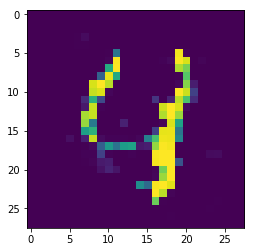

3
[1.64138907e-18 6.26035762e-06 1.90224545e-13 3.14819962e-01
 9.55425600e-11 5.11546740e-19 2.57017779e-12 4.30779219e-05
 1.53261362e-06 7.59421660e-20]


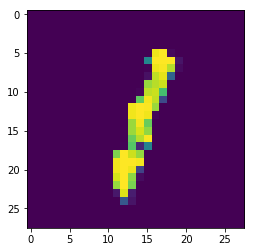

0
[2.34267324e-01 4.64084077e-10 3.89126353e-02 5.30557751e-11
 1.63738370e-01 2.76839529e-09 3.59097787e-04 7.98450195e-09
 9.33562685e-03 1.53272902e-06]


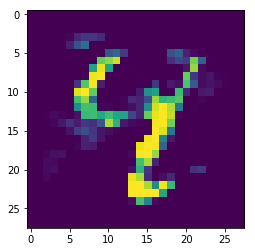

0
[3.01277055e-06 1.34781964e-12 2.26934546e-07 1.62653066e-06
 1.74995392e-07 8.12922533e-17 1.17504341e-14 1.51689737e-13
 1.03460526e-14 2.31730928e-06]


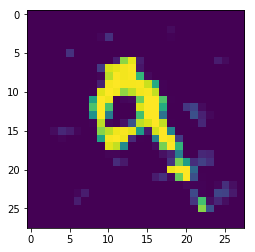

1
[9.48613679e-24 1.60021145e-07 1.44172752e-09 5.93610946e-18
 7.91471722e-18 3.17970255e-08 5.08383058e-10 2.26640024e-20
 1.58916595e-11 5.26621730e-22]


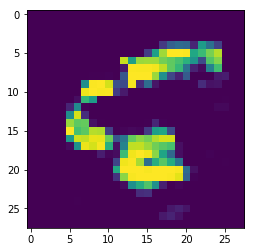

0
[1.43258712e-05 4.32957611e-22 4.31063722e-16 2.01778626e-20
 1.00588349e-09 2.00830502e-25 3.13408037e-07 8.88110571e-06
 3.50663660e-12 3.32648003e-17]


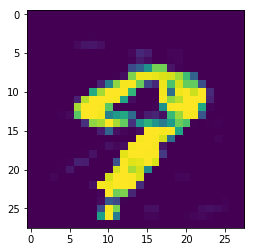

In [11]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


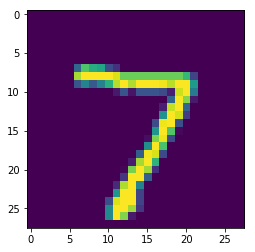

2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


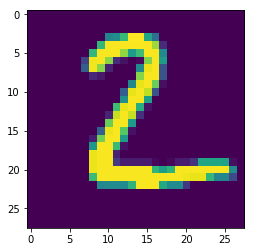

1
[1.83486454e-32 1.00000000e+00 2.11208282e-27 4.90580004e-33
 8.89557054e-32 1.82131045e-22 6.35550784e-33 1.74793226e-30
 4.24750025e-31 3.27709159e-34]


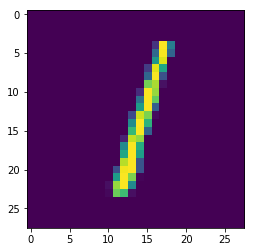

0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


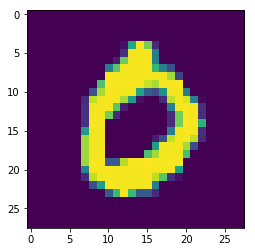

4
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


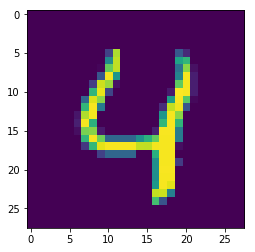

1
[5.26412566e-38 1.00000000e+00 4.64184903e-33 0.00000000e+00
 5.45070715e-34 4.38577130e-25 0.00000000e+00 2.21901558e-34
 4.42465625e-33 0.00000000e+00]


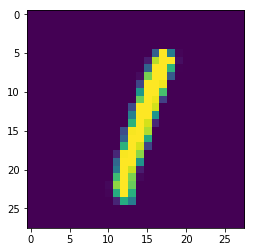

4
[0.00000000e+00 0.00000000e+00 2.51612431e-34 0.00000000e+00
 1.00000000e+00 0.00000000e+00 8.24174216e-36 2.06256212e-31
 1.33182836e-37 0.00000000e+00]


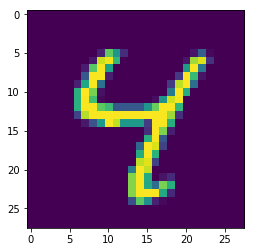

9
[0.00000000e+00 1.39759144e-24 1.98937927e-33 5.59860786e-17
 0.00000000e+00 6.96735246e-36 1.28629880e-32 0.00000000e+00
 1.25478435e-36 1.00000000e+00]


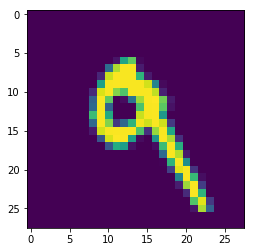

5
[1.03084536e-32 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.91199311e-25 9.99987483e-01 6.29963899e-15 0.00000000e+00
 3.18275149e-21 0.00000000e+00]


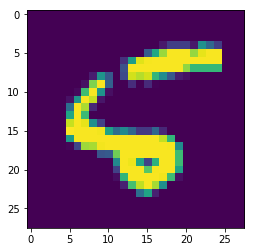

9
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.07243472e-31
 0.00000000e+00 1.00000000e+00]


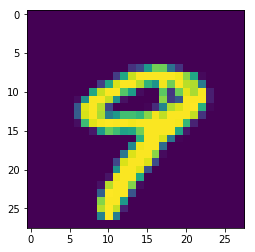

In [14]:
y_pred = hingenet.predict_model(sess, X_test[:10, :, :, np.newaxis])

for x, y in zip(X_test[:10], y_pred):
    print(np.argmax(y))
    print(y)
    plt.imshow(x)
    plt.show()

In [43]:
y_pred = hingenet.predict_model(sess, X_test[:, :, :, np.newaxis])
y_sort = np.argsort(y_pred, axis=1)[:, ::-1]
y_final = np.zeros(len(y_pred)) - 1
for i in range(len(y_pred)):
    d = y_pred[i, y_sort[i, 0]] - y_pred[i, y_sort[i, 1]]
    if d >= 0.75:
        y_final[i] = y_sort[i, 0]
np.mean(y_final == np.argmax(y_test, axis=1))

0.9785

In [47]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target,
             'confidence': 0.75}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

# print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

[INFO 2018-10-17 09:17:14,877 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.984, 0.03265167073532939)
0.75


[DEBUG 2018-10-17 09:17:15,270 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 09:17:15,296 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 09:17:15,396 cleverhans]     Iteration 0 of 200: loss=2.95e+03 l2=0
[DEBUG 2018-10-17 09:17:15,570 cleverhans]     Iteration 20 of 200: loss=539 l2=20.3
[DEBUG 2018-10-17 09:17:15,732 cleverhans]     Iteration 40 of 200: loss=206 l2=33.3
[DEBUG 2018-10-17 09:17:15,890 cleverhans]     Iteration 60 of 200: loss=79.5 l2=35.4
[DEBUG 2018-10-17 09:17:16,036 cleverhans]     Iteration 80 of 200: loss=49 l2=37.7
[DEBUG 2018-10-17 09:17:16,179 cleverhans]     Iteration 100 of 200: loss=40.9 l2=36.8
[DEBUG 2018-10-17 09:17:16,327 cleverhans]     Iteration 120 of 200: loss=36.9 l2=35.2
[DEBUG 2018-10-17 09:17:16,480 cleverhans]     Iteration 140 of 200: loss=34.9 l2=33.7
[DEBUG 2018-10-17 09:17:16,639 cleverhans]     Iteration 160 of 200: loss=32.9 l2=32.3
[DEBUG 2018-10-17 09:17:16,792 cleverhans]     Iteration 180 of 200: l

[DEBUG 2018-10-17 09:17:26,077 cleverhans]     Iteration 20 of 200: loss=257 l2=19.2
[DEBUG 2018-10-17 09:17:26,224 cleverhans]     Iteration 40 of 200: loss=106 l2=30.3
[DEBUG 2018-10-17 09:17:26,359 cleverhans]     Iteration 60 of 200: loss=56.2 l2=31.8
[DEBUG 2018-10-17 09:17:26,491 cleverhans]     Iteration 80 of 200: loss=39.5 l2=32.3
[DEBUG 2018-10-17 09:17:26,625 cleverhans]     Iteration 100 of 200: loss=33.8 l2=30.7
[DEBUG 2018-10-17 09:17:26,762 cleverhans]     Iteration 120 of 200: loss=30.5 l2=28.7
[DEBUG 2018-10-17 09:17:26,914 cleverhans]     Iteration 140 of 200: loss=27.9 l2=27.1
[DEBUG 2018-10-17 09:17:27,069 cleverhans]     Iteration 160 of 200: loss=25.9 l2=25.7
[DEBUG 2018-10-17 09:17:27,218 cleverhans]     Iteration 180 of 200: loss=24.3 l2=24.3
[DEBUG 2018-10-17 09:17:27,356 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 09:17:27,356 cleverhans]    Mean successful distortion: 4.672
[DEBUG 2018-10-17 09:17:27,35

[DEBUG 2018-10-17 09:17:36,802 cleverhans]     Iteration 60 of 200: loss=44.4 l2=28.3
[DEBUG 2018-10-17 09:17:36,937 cleverhans]     Iteration 80 of 200: loss=31.9 l2=28.3
[DEBUG 2018-10-17 09:17:37,075 cleverhans]     Iteration 100 of 200: loss=26.3 l2=25.1
[DEBUG 2018-10-17 09:17:37,214 cleverhans]     Iteration 120 of 200: loss=22.9 l2=22.5
[DEBUG 2018-10-17 09:17:37,363 cleverhans]     Iteration 140 of 200: loss=20.8 l2=20.4
[DEBUG 2018-10-17 09:17:37,514 cleverhans]     Iteration 160 of 200: loss=19.1 l2=18.8
[DEBUG 2018-10-17 09:17:37,660 cleverhans]     Iteration 180 of 200: loss=17.8 l2=17.5
[DEBUG 2018-10-17 09:17:37,795 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 09:17:37,797 cleverhans]    Mean successful distortion: 3.886
[DEBUG 2018-10-17 09:17:37,798 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-17 09:17:37,803 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 09:17:37,811 cleverhans

[DEBUG 2018-10-17 09:17:47,519 cleverhans]     Iteration 80 of 200: loss=54 l2=39.1
[DEBUG 2018-10-17 09:17:47,670 cleverhans]     Iteration 100 of 200: loss=44.1 l2=38.4
[DEBUG 2018-10-17 09:17:47,824 cleverhans]     Iteration 120 of 200: loss=38.9 l2=36.7
[DEBUG 2018-10-17 09:17:47,986 cleverhans]     Iteration 140 of 200: loss=35.8 l2=35
[DEBUG 2018-10-17 09:17:48,140 cleverhans]     Iteration 160 of 200: loss=34 l2=33.5
[DEBUG 2018-10-17 09:17:48,292 cleverhans]     Iteration 180 of 200: loss=32.2 l2=32.1
[DEBUG 2018-10-17 09:17:48,446 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 09:17:48,447 cleverhans]    Mean successful distortion: 5.347
[DEBUG 2018-10-17 09:17:48,449 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 09:17:48,456 cleverhans]     Iteration 0 of 200: loss=1.39e+03 l2=0
[DEBUG 2018-10-17 09:17:48,619 cleverhans]     Iteration 20 of 200: loss=296 l2=20.3
[DEBUG 2018-10-17 09:17:48,764 cleverhans]     It

[DEBUG 2018-10-17 09:17:58,390 cleverhans]     Iteration 120 of 200: loss=35.2 l2=30.7
[DEBUG 2018-10-17 09:17:58,549 cleverhans]     Iteration 140 of 200: loss=31.8 l2=28.8
[DEBUG 2018-10-17 09:17:58,708 cleverhans]     Iteration 160 of 200: loss=29.7 l2=27.3
[DEBUG 2018-10-17 09:17:58,867 cleverhans]     Iteration 180 of 200: loss=27.9 l2=25.7
[DEBUG 2018-10-17 09:17:59,019 cleverhans]   Successfully generated adversarial examples on 99 of 100 instances.
[DEBUG 2018-10-17 09:17:59,020 cleverhans]    Mean successful distortion: 4.762
[DEBUG 2018-10-17 09:17:59,021 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 09:17:59,029 cleverhans]     Iteration 0 of 200: loss=2.8e+03 l2=0
[DEBUG 2018-10-17 09:17:59,194 cleverhans]     Iteration 20 of 200: loss=485 l2=19.2
[DEBUG 2018-10-17 09:17:59,346 cleverhans]     Iteration 40 of 200: loss=289 l2=29.6
[DEBUG 2018-10-17 09:17:59,498 cleverhans]     Iteration 60 of 200: loss=188 l2=29.8
[DEBUG 2018-10-17 09:17:59,643 cleverhans]     I

4.196702


In [49]:
y_pred = hingenet.predict_model(sess, adv)
y_sort = np.argsort(y_pred, axis=1)[:, ::-1]
y_final = np.zeros(len(y_pred)) - 1
for i in range(len(y_pred)):
    d = y_pred[i, y_sort[i, 0]] - y_pred[i, y_sort[i, 1]]
    if d >= 0.75:
        y_final[i] = y_sort[i, 0]
np.mean(y_final == np.argmax(y_target, axis=1))

0.11

0
[9.87213314e-01 1.15015148e-07 2.28699297e-01 3.69029681e-06
 4.95246617e-08 4.17200718e-09 1.97796561e-02 1.51309460e-01
 2.44847918e-03 4.88812546e-08]


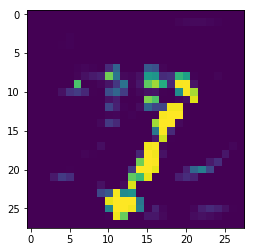

0
[9.99925852e-01 0.00000000e+00 9.96311128e-01 4.92309647e-36
 3.20801298e-33 0.00000000e+00 1.98654157e-12 0.00000000e+00
 1.98926158e-22 2.62670118e-30]


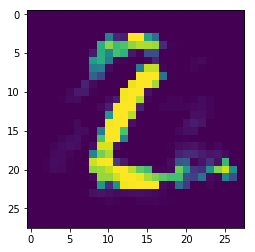

9
[3.24056124e-08 7.85590673e-04 8.13192455e-05 2.26209022e-06
 1.46950388e-05 2.14569321e-10 1.63965680e-07 1.35249634e-08
 8.51460500e-04 4.97642718e-03]


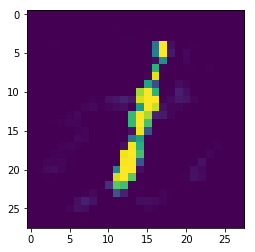

1
[4.89851053e-13 2.25228420e-03 1.04433135e-03 3.82706048e-06
 8.56763933e-13 1.37036773e-06 2.92034192e-12 1.07528242e-09
 2.82543722e-09 2.48900983e-10]


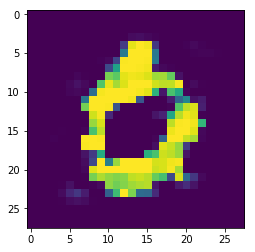

0
[1.91447526e-01 3.75955311e-09 6.93571800e-03 1.29486405e-04
 3.94349806e-02 2.53734970e-06 3.93873052e-04 1.14500942e-03
 3.69858393e-03 1.43853440e-05]


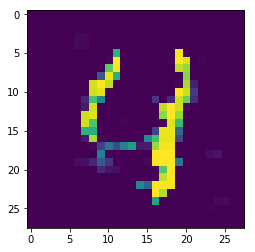

3
[1.67413312e-18 7.81963899e-06 1.83446601e-13 2.75974363e-01
 1.00708088e-10 5.47059982e-19 2.30862551e-12 4.31826411e-05
 1.54652946e-06 7.46764311e-20]


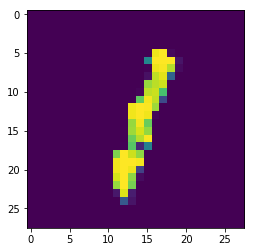

0
[8.54646981e-01 8.58221567e-12 5.93455553e-01 2.81915758e-11
 1.39788049e-03 8.97418195e-10 1.26940955e-04 5.93347638e-09
 6.29008859e-02 9.68935524e-07]


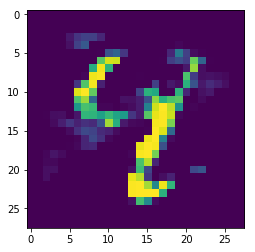

0
[2.95880386e-06 6.29135904e-13 4.04062860e-07 9.42374072e-07
 2.14496794e-07 3.22796395e-16 6.33102918e-15 1.23665143e-13
 1.23060352e-14 7.20400806e-07]


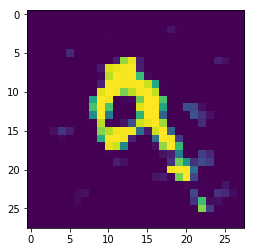

1
[1.48325103e-25 2.72940426e-08 1.30055472e-11 8.93269552e-19
 7.89255415e-19 8.57980620e-09 4.12220084e-12 2.94332963e-20
 4.42237885e-10 2.17967139e-24]


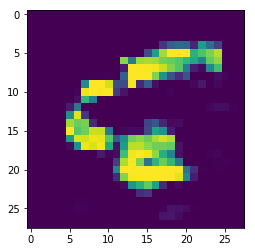

0
[6.66160304e-06 2.16913096e-22 4.95903433e-16 1.39172621e-20
 2.95222818e-10 9.13989159e-26 1.37638168e-07 1.67974906e-06
 4.81798108e-12 1.13946776e-16]


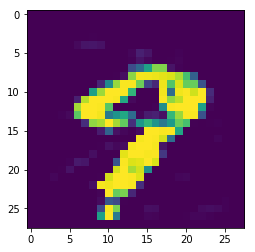

In [48]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

---

# V8

Large network, margin: 1

In [54]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v8", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v8.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

Saved weights not found...
Model was built, but no weight was loaded
============= EPOCH: 0 =============
STEP: 0 	Loss: 1.0454
STEP: 50 	Loss: 0.1294
STEP: 100 	Loss: 0.1554
STEP: 150 	Loss: 0.0424
STEP: 200 	Loss: 0.0800
STEP: 250 	Loss: 0.0594
STEP: 300 	Loss: 0.0424
STEP: 350 	Loss: 0.0926
STEP: 400 	Loss: 0.1004
Train Acc|Loss:	0.9836|0.0439
Val Acc|Loss:	0.9790|0.0555
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.0235
STEP: 50 	Loss: 0.0064
STEP: 100 	Loss: 0.0566
STEP: 150 	Loss: 0.0247
STEP: 200 	Loss: 0.0259
STEP: 250 	Loss: 0.0196
STEP: 300 	Loss: 0.0188
STEP: 350 	Loss: 0.0259
STEP: 400 	Loss: 0.0430
Train Acc|Loss:	0.9916|0.0233
Val Acc|Loss:	0.9840|0.0403
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0138
STEP: 50 	Loss: 0.0555
STEP: 100 	Loss: 0.0226
STEP: 150 	Loss: 0.0373
STEP: 200 	Loss: 0.0284
STEP: 250 	Loss: 0.0324
STEP: 300 	Loss: 0.0334
STEP: 350 	Loss: 0.0066
STEP: 400 	Loss: 0.0363
Train Acc|Loss:	0.9948|0.0145
Val Acc|Loss:	0.9870|0.0336
=======

In [55]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

2.9790378
60.13557
111.87307
3443.5757
221.35944
18.96972


In [56]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

[INFO 2018-10-17 21:58:43,483 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.985, 0.03473391541838646)


[DEBUG 2018-10-17 21:58:43,747 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 21:58:43,771 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 21:58:43,868 cleverhans]     Iteration 0 of 200: loss=82.1 l2=0
[DEBUG 2018-10-17 21:58:44,036 cleverhans]     Iteration 20 of 200: loss=34.2 l2=16
[DEBUG 2018-10-17 21:58:44,200 cleverhans]     Iteration 40 of 200: loss=24 l2=17.7
[DEBUG 2018-10-17 21:58:44,363 cleverhans]     Iteration 60 of 200: loss=20.7 l2=16.3
[DEBUG 2018-10-17 21:58:44,528 cleverhans]     Iteration 80 of 200: loss=16.5 l2=14.6
[DEBUG 2018-10-17 21:58:44,683 cleverhans]     Iteration 100 of 200: loss=12.9 l2=11.9
[DEBUG 2018-10-17 21:58:44,832 cleverhans]     Iteration 120 of 200: loss=11 l2=10.5
[DEBUG 2018-10-17 21:58:44,983 cleverhans]     Iteration 140 of 200: loss=9.91 l2=9.53
[DEBUG 2018-10-17 21:58:45,127 cleverhans]     Iteration 160 of 200: loss=9.29 l2=8.88
[DEBUG 2018-10-17 21:58:45,268 cleverhans]     Iteration 180 of 200: loss=8.

[DEBUG 2018-10-17 21:58:54,675 cleverhans]     Iteration 20 of 200: loss=21.3 l2=10.6
[DEBUG 2018-10-17 21:58:54,817 cleverhans]     Iteration 40 of 200: loss=16.7 l2=10.7
[DEBUG 2018-10-17 21:58:54,963 cleverhans]     Iteration 60 of 200: loss=15.7 l2=10.2
[DEBUG 2018-10-17 21:58:55,115 cleverhans]     Iteration 80 of 200: loss=13.7 l2=9.68
[DEBUG 2018-10-17 21:58:55,263 cleverhans]     Iteration 100 of 200: loss=10.9 l2=8.47
[DEBUG 2018-10-17 21:58:55,409 cleverhans]     Iteration 120 of 200: loss=9.29 l2=7.73
[DEBUG 2018-10-17 21:58:55,556 cleverhans]     Iteration 140 of 200: loss=8.36 l2=7.17
[DEBUG 2018-10-17 21:58:55,701 cleverhans]     Iteration 160 of 200: loss=7.74 l2=6.85
[DEBUG 2018-10-17 21:58:55,848 cleverhans]     Iteration 180 of 200: loss=7.33 l2=6.72
[DEBUG 2018-10-17 21:58:55,992 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 21:58:55,994 cleverhans]    Mean successful distortion: 2.559
[DEBUG 2018-10-17 21:58:55,

[DEBUG 2018-10-17 21:59:05,570 cleverhans]     Iteration 60 of 200: loss=16.7 l2=7.87
[DEBUG 2018-10-17 21:59:05,720 cleverhans]     Iteration 80 of 200: loss=13.9 l2=8.06
[DEBUG 2018-10-17 21:59:05,880 cleverhans]     Iteration 100 of 200: loss=11.6 l2=7.57
[DEBUG 2018-10-17 21:59:06,033 cleverhans]     Iteration 120 of 200: loss=10.1 l2=7.08
[DEBUG 2018-10-17 21:59:06,182 cleverhans]     Iteration 140 of 200: loss=9.23 l2=7.05
[DEBUG 2018-10-17 21:59:06,335 cleverhans]     Iteration 160 of 200: loss=8.63 l2=6.93
[DEBUG 2018-10-17 21:59:06,486 cleverhans]     Iteration 180 of 200: loss=8.25 l2=6.88
[DEBUG 2018-10-17 21:59:06,643 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 21:59:06,644 cleverhans]    Mean successful distortion: 2.659
[DEBUG 2018-10-17 21:59:06,645 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-17 21:59:06,650 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 21:59:06,657 cleverhans

[DEBUG 2018-10-17 21:59:16,585 cleverhans]     Iteration 80 of 200: loss=17.4 l2=14.9
[DEBUG 2018-10-17 21:59:16,744 cleverhans]     Iteration 100 of 200: loss=13.8 l2=12.5
[DEBUG 2018-10-17 21:59:16,902 cleverhans]     Iteration 120 of 200: loss=11.6 l2=10.9
[DEBUG 2018-10-17 21:59:17,053 cleverhans]     Iteration 140 of 200: loss=10.3 l2=9.72
[DEBUG 2018-10-17 21:59:17,201 cleverhans]     Iteration 160 of 200: loss=9.73 l2=9.26
[DEBUG 2018-10-17 21:59:17,346 cleverhans]     Iteration 180 of 200: loss=9.08 l2=8.75
[DEBUG 2018-10-17 21:59:17,469 cleverhans]   Successfully generated adversarial examples on 97 of 100 instances.
[DEBUG 2018-10-17 21:59:17,470 cleverhans]    Mean successful distortion: 2.745
[DEBUG 2018-10-17 21:59:17,472 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 21:59:17,479 cleverhans]     Iteration 0 of 200: loss=68.8 l2=0
[DEBUG 2018-10-17 21:59:17,644 cleverhans]     Iteration 20 of 200: loss=33.8 l2=11.4
[DEBUG 2018-10-17 21:59:17,796 cleverhans]     

[DEBUG 2018-10-17 21:59:27,693 cleverhans]     Iteration 120 of 200: loss=10.5 l2=8.67
[DEBUG 2018-10-17 21:59:27,847 cleverhans]     Iteration 140 of 200: loss=9.65 l2=8.18
[DEBUG 2018-10-17 21:59:28,003 cleverhans]     Iteration 160 of 200: loss=9.01 l2=7.81
[DEBUG 2018-10-17 21:59:28,154 cleverhans]     Iteration 180 of 200: loss=8.52 l2=7.52
[DEBUG 2018-10-17 21:59:28,306 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 21:59:28,307 cleverhans]    Mean successful distortion: 2.691
[DEBUG 2018-10-17 21:59:28,308 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 21:59:28,315 cleverhans]     Iteration 0 of 200: loss=41.5 l2=0
[DEBUG 2018-10-17 21:59:28,475 cleverhans]     Iteration 20 of 200: loss=21.6 l2=7.78
[DEBUG 2018-10-17 21:59:28,631 cleverhans]     Iteration 40 of 200: loss=16.8 l2=8.48
[DEBUG 2018-10-17 21:59:28,780 cleverhans]     Iteration 60 of 200: loss=15.5 l2=8.43
[DEBUG 2018-10-17 21:59:28,936 cleverhans]     

(1.0, 0.9641328139305114)
2.7429702


In [61]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v8-1", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v8-1.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

Saved weights not found...
Model was built, but no weight was loaded
============= EPOCH: 0 =============
STEP: 0 	Loss: 10.0423
STEP: 50 	Loss: 3.5214
STEP: 100 	Loss: 2.6468
STEP: 150 	Loss: 0.4642
STEP: 200 	Loss: 0.7819
STEP: 250 	Loss: 1.3110
STEP: 300 	Loss: 0.9057
STEP: 350 	Loss: 0.9686
STEP: 400 	Loss: 0.1006
Train Acc|Loss:	0.9818|0.4842
Val Acc|Loss:	0.9802|0.5742
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.5011
STEP: 50 	Loss: 0.5545
STEP: 100 	Loss: 0.3801
STEP: 150 	Loss: 0.1141
STEP: 200 	Loss: 0.0512
STEP: 250 	Loss: 0.4077
STEP: 300 	Loss: 0.0388
STEP: 350 	Loss: 0.3189
STEP: 400 	Loss: 0.4626
Train Acc|Loss:	0.9896|0.2805
Val Acc|Loss:	0.9848|0.4423
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.3683
STEP: 50 	Loss: 0.3357
STEP: 100 	Loss: 0.1061
STEP: 150 	Loss: 0.4914
STEP: 200 	Loss: 0.0964
STEP: 250 	Loss: 0.3060
STEP: 300 	Loss: 0.0360
STEP: 350 	Loss: 0.5559
STEP: 400 	Loss: 0.2149
Train Acc|Loss:	0.9913|0.2247
Val Acc|Loss:	0.9845|0.3944
======

In [62]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

4.693959
92.208046
107.71911
3116.6309
242.97774
20.951023


In [63]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

[INFO 2018-10-17 22:03:50,256 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.992, 0.22169152250885962)


[DEBUG 2018-10-17 22:03:50,532 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 22:03:50,562 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 22:03:50,663 cleverhans]     Iteration 0 of 200: loss=1.02e+03 l2=0
[DEBUG 2018-10-17 22:03:50,840 cleverhans]     Iteration 20 of 200: loss=261 l2=22.6
[DEBUG 2018-10-17 22:03:50,996 cleverhans]     Iteration 40 of 200: loss=89.3 l2=39.8
[DEBUG 2018-10-17 22:03:51,137 cleverhans]     Iteration 60 of 200: loss=46.9 l2=39.3
[DEBUG 2018-10-17 22:03:51,281 cleverhans]     Iteration 80 of 200: loss=38.2 l2=38
[DEBUG 2018-10-17 22:03:51,439 cleverhans]     Iteration 100 of 200: loss=34.3 l2=34.2
[DEBUG 2018-10-17 22:03:51,600 cleverhans]     Iteration 120 of 200: loss=31.3 l2=31.3
[DEBUG 2018-10-17 22:03:51,759 cleverhans]     Iteration 140 of 200: loss=29.1 l2=29.1
[DEBUG 2018-10-17 22:03:51,923 cleverhans]     Iteration 160 of 200: loss=27.3 l2=27.3
[DEBUG 2018-10-17 22:03:52,069 cleverhans]     Iteration 180 of 200: 

[DEBUG 2018-10-17 22:04:01,060 cleverhans]     Iteration 0 of 200: loss=495 l2=0
[DEBUG 2018-10-17 22:04:01,210 cleverhans]     Iteration 20 of 200: loss=135 l2=22
[DEBUG 2018-10-17 22:04:01,349 cleverhans]     Iteration 40 of 200: loss=53.4 l2=35.5
[DEBUG 2018-10-17 22:04:01,478 cleverhans]     Iteration 60 of 200: loss=34.2 l2=32.2
[DEBUG 2018-10-17 22:04:01,615 cleverhans]     Iteration 80 of 200: loss=29 l2=28.9
[DEBUG 2018-10-17 22:04:01,758 cleverhans]     Iteration 100 of 200: loss=25.4 l2=25.3
[DEBUG 2018-10-17 22:04:01,897 cleverhans]     Iteration 120 of 200: loss=23 l2=23
[DEBUG 2018-10-17 22:04:02,057 cleverhans]     Iteration 140 of 200: loss=21.2 l2=21.1
[DEBUG 2018-10-17 22:04:02,206 cleverhans]     Iteration 160 of 200: loss=19.7 l2=19.6
[DEBUG 2018-10-17 22:04:02,358 cleverhans]     Iteration 180 of 200: loss=18.4 l2=18.4
[DEBUG 2018-10-17 22:04:02,501 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 22:04:02,502 clev

[DEBUG 2018-10-17 22:04:11,825 cleverhans]     Iteration 60 of 200: loss=35.3 l2=25.3
[DEBUG 2018-10-17 22:04:11,970 cleverhans]     Iteration 80 of 200: loss=24.1 l2=23.7
[DEBUG 2018-10-17 22:04:12,117 cleverhans]     Iteration 100 of 200: loss=20.1 l2=19.9
[DEBUG 2018-10-17 22:04:12,264 cleverhans]     Iteration 120 of 200: loss=17.6 l2=17.6
[DEBUG 2018-10-17 22:04:12,413 cleverhans]     Iteration 140 of 200: loss=15.8 l2=15.7
[DEBUG 2018-10-17 22:04:12,559 cleverhans]     Iteration 160 of 200: loss=14.6 l2=14.4
[DEBUG 2018-10-17 22:04:12,700 cleverhans]     Iteration 180 of 200: loss=13.4 l2=13.3
[DEBUG 2018-10-17 22:04:12,835 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 22:04:12,836 cleverhans]    Mean successful distortion: 3.378
[DEBUG 2018-10-17 22:04:12,837 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-17 22:04:12,845 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 22:04:12,852 cleverhans

[DEBUG 2018-10-17 22:04:22,351 cleverhans]     Iteration 80 of 200: loss=40 l2=38.8
[DEBUG 2018-10-17 22:04:22,505 cleverhans]     Iteration 100 of 200: loss=35.3 l2=35.1
[DEBUG 2018-10-17 22:04:22,651 cleverhans]     Iteration 120 of 200: loss=32 l2=31.9
[DEBUG 2018-10-17 22:04:22,817 cleverhans]     Iteration 140 of 200: loss=29.5 l2=29.5
[DEBUG 2018-10-17 22:04:22,975 cleverhans]     Iteration 160 of 200: loss=27.6 l2=27.6
[DEBUG 2018-10-17 22:04:23,134 cleverhans]     Iteration 180 of 200: loss=26.1 l2=26.1
[DEBUG 2018-10-17 22:04:23,283 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 22:04:23,284 cleverhans]    Mean successful distortion: 4.88
[DEBUG 2018-10-17 22:04:23,285 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 22:04:23,294 cleverhans]     Iteration 0 of 200: loss=532 l2=0
[DEBUG 2018-10-17 22:04:23,457 cleverhans]     Iteration 20 of 200: loss=153 l2=22.6
[DEBUG 2018-10-17 22:04:23,603 cleverhans]     Iterat

[DEBUG 2018-10-17 22:04:32,999 cleverhans]     Iteration 120 of 200: loss=23.9 l2=23.8
[DEBUG 2018-10-17 22:04:33,159 cleverhans]     Iteration 140 of 200: loss=22 l2=21.9
[DEBUG 2018-10-17 22:04:33,309 cleverhans]     Iteration 160 of 200: loss=20.2 l2=20.2
[DEBUG 2018-10-17 22:04:33,447 cleverhans]     Iteration 180 of 200: loss=18.9 l2=18.7
[DEBUG 2018-10-17 22:04:33,579 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 22:04:33,580 cleverhans]    Mean successful distortion: 4.081
[DEBUG 2018-10-17 22:04:33,581 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 22:04:33,589 cleverhans]     Iteration 0 of 200: loss=257 l2=0
[DEBUG 2018-10-17 22:04:33,749 cleverhans]     Iteration 20 of 200: loss=81.5 l2=21.1
[DEBUG 2018-10-17 22:04:33,889 cleverhans]     Iteration 40 of 200: loss=41.6 l2=31
[DEBUG 2018-10-17 22:04:34,029 cleverhans]     Iteration 60 of 200: loss=29.8 l2=25.7
[DEBUG 2018-10-17 22:04:34,167 cleverhans]     Itera

(1.0, 8.469424919128418)
3.430837


In [68]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v8-2", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v8-2.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

Saved weights not found...
Model was built, but no weight was loaded
============= EPOCH: 0 =============
STEP: 0 	Loss: 100.0446
STEP: 50 	Loss: 58.5423
STEP: 100 	Loss: 24.0650
STEP: 150 	Loss: 25.9560
STEP: 200 	Loss: 15.4947
STEP: 250 	Loss: 15.8540
STEP: 300 	Loss: 10.4332
STEP: 350 	Loss: 11.9938
STEP: 400 	Loss: 7.3848
Train Acc|Loss:	0.9726|7.0190
Val Acc|Loss:	0.9658|8.6054
============= EPOCH: 1 =============
STEP: 0 	Loss: 5.2275
STEP: 50 	Loss: 8.1679
STEP: 100 	Loss: 1.8880
STEP: 150 	Loss: 9.0002
STEP: 200 	Loss: 3.9049
STEP: 250 	Loss: 5.5828
STEP: 300 	Loss: 1.8692
STEP: 350 	Loss: 5.3221
STEP: 400 	Loss: 4.8266
Train Acc|Loss:	0.9799|5.4042
Val Acc|Loss:	0.9735|7.2235
============= EPOCH: 2 =============
STEP: 0 	Loss: 6.1034
STEP: 50 	Loss: 4.2902
STEP: 100 	Loss: 4.0507
STEP: 150 	Loss: 2.2749
STEP: 200 	Loss: 1.2909
STEP: 250 	Loss: 2.4134
STEP: 300 	Loss: 6.9187
STEP: 350 	Loss: 0.6402
STEP: 400 	Loss: 5.4016
Train Acc|Loss:	0.9885|3.1224
Val Acc|Loss:	0.9823|4.698

In [69]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

8.9578085
175.16335
126.18854
4695.163
303.47125
23.389729


In [70]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

[INFO 2018-10-17 22:07:41,158 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.989, 3.218773218154907)


[DEBUG 2018-10-17 22:07:41,417 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 22:07:41,437 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 22:07:41,523 cleverhans]     Iteration 0 of 200: loss=1.2e+04 l2=0
[DEBUG 2018-10-17 22:07:41,695 cleverhans]     Iteration 20 of 200: loss=2.58e+03 l2=21.2
[DEBUG 2018-10-17 22:07:41,854 cleverhans]     Iteration 40 of 200: loss=727 l2=38.3
[DEBUG 2018-10-17 22:07:41,984 cleverhans]     Iteration 60 of 200: loss=153 l2=42
[DEBUG 2018-10-17 22:07:42,099 cleverhans]     Iteration 80 of 200: loss=53.3 l2=45.6
[DEBUG 2018-10-17 22:07:42,216 cleverhans]     Iteration 100 of 200: loss=45.1 l2=45.1
[DEBUG 2018-10-17 22:07:42,337 cleverhans]     Iteration 120 of 200: loss=44.1 l2=44.1
[DEBUG 2018-10-17 22:07:42,460 cleverhans]     Iteration 140 of 200: loss=43.2 l2=43.2
[DEBUG 2018-10-17 22:07:42,586 cleverhans]     Iteration 160 of 200: loss=42.3 l2=42.3
[DEBUG 2018-10-17 22:07:42,715 cleverhans]     Iteration 180 of 200

[DEBUG 2018-10-17 22:07:50,910 cleverhans]     Iteration 0 of 200: loss=5.88e+03 l2=0
[DEBUG 2018-10-17 22:07:51,076 cleverhans]     Iteration 20 of 200: loss=1.23e+03 l2=21.2
[DEBUG 2018-10-17 22:07:51,233 cleverhans]     Iteration 40 of 200: loss=322 l2=37.9
[DEBUG 2018-10-17 22:07:51,374 cleverhans]     Iteration 60 of 200: loss=69.2 l2=40.9
[DEBUG 2018-10-17 22:07:51,496 cleverhans]     Iteration 80 of 200: loss=43.1 l2=42.8
[DEBUG 2018-10-17 22:07:51,611 cleverhans]     Iteration 100 of 200: loss=41.5 l2=41.5
[DEBUG 2018-10-17 22:07:51,721 cleverhans]     Iteration 120 of 200: loss=40 l2=40
[DEBUG 2018-10-17 22:07:51,847 cleverhans]     Iteration 140 of 200: loss=38.8 l2=38.8
[DEBUG 2018-10-17 22:07:51,975 cleverhans]     Iteration 160 of 200: loss=37.7 l2=37.7
[DEBUG 2018-10-17 22:07:52,109 cleverhans]     Iteration 180 of 200: loss=36.6 l2=36.6
[DEBUG 2018-10-17 22:07:52,245 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 22:0

[DEBUG 2018-10-17 22:08:00,829 cleverhans]     Iteration 40 of 200: loss=277 l2=36.1
[DEBUG 2018-10-17 22:08:00,956 cleverhans]     Iteration 60 of 200: loss=63.5 l2=39.4
[DEBUG 2018-10-17 22:08:01,076 cleverhans]     Iteration 80 of 200: loss=42.2 l2=42.1
[DEBUG 2018-10-17 22:08:01,195 cleverhans]     Iteration 100 of 200: loss=39.6 l2=39.6
[DEBUG 2018-10-17 22:08:01,320 cleverhans]     Iteration 120 of 200: loss=37.3 l2=37.3
[DEBUG 2018-10-17 22:08:01,459 cleverhans]     Iteration 140 of 200: loss=35.3 l2=35.3
[DEBUG 2018-10-17 22:08:01,605 cleverhans]     Iteration 160 of 200: loss=33.7 l2=33.7
[DEBUG 2018-10-17 22:08:01,758 cleverhans]     Iteration 180 of 200: loss=32.3 l2=32.3
[DEBUG 2018-10-17 22:08:01,904 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 22:08:01,905 cleverhans]    Mean successful distortion: 5.431
[DEBUG 2018-10-17 22:08:01,906 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-17 22:08:01,

[DEBUG 2018-10-17 22:08:10,507 cleverhans]     Iteration 60 of 200: loss=95.6 l2=43.3
[DEBUG 2018-10-17 22:08:10,632 cleverhans]     Iteration 80 of 200: loss=51.3 l2=47.8
[DEBUG 2018-10-17 22:08:10,746 cleverhans]     Iteration 100 of 200: loss=48.5 l2=47
[DEBUG 2018-10-17 22:08:10,856 cleverhans]     Iteration 120 of 200: loss=45.7 l2=45.7
[DEBUG 2018-10-17 22:08:10,960 cleverhans]     Iteration 140 of 200: loss=44.6 l2=44.6
[DEBUG 2018-10-17 22:08:11,089 cleverhans]     Iteration 160 of 200: loss=43.5 l2=43.5
[DEBUG 2018-10-17 22:08:11,223 cleverhans]     Iteration 180 of 200: loss=42.5 l2=42.5
[DEBUG 2018-10-17 22:08:11,352 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 22:08:11,353 cleverhans]    Mean successful distortion: 5.921
[DEBUG 2018-10-17 22:08:11,355 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 22:08:11,363 cleverhans]     Iteration 0 of 200: loss=6.03e+03 l2=0
[DEBUG 2018-10-17 22:08:11,527 cleverhans]  

[DEBUG 2018-10-17 22:08:20,169 cleverhans]     Iteration 100 of 200: loss=41.3 l2=40.9
[DEBUG 2018-10-17 22:08:20,295 cleverhans]     Iteration 120 of 200: loss=39.6 l2=39.6
[DEBUG 2018-10-17 22:08:20,424 cleverhans]     Iteration 140 of 200: loss=38.4 l2=38.4
[DEBUG 2018-10-17 22:08:20,564 cleverhans]     Iteration 160 of 200: loss=37.3 l2=37.3
[DEBUG 2018-10-17 22:08:20,712 cleverhans]     Iteration 180 of 200: loss=36.3 l2=36.3
[DEBUG 2018-10-17 22:08:20,859 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 22:08:20,860 cleverhans]    Mean successful distortion: 5.635
[DEBUG 2018-10-17 22:08:20,862 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 22:08:20,869 cleverhans]     Iteration 0 of 200: loss=3e+03 l2=0
[DEBUG 2018-10-17 22:08:21,030 cleverhans]     Iteration 20 of 200: loss=600 l2=21.2
[DEBUG 2018-10-17 22:08:21,179 cleverhans]     Iteration 40 of 200: loss=204 l2=36.5
[DEBUG 2018-10-17 22:08:21,302 cleverhans]     

(1.0, 70.39868859863282)
5.5572596


---

# V9

margin: 1e2, last layer is softmax

In [75]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v9", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v9.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

Saved weights not found...
Model was built, but no weight was loaded
============= EPOCH: 0 =============
STEP: 0 	Loss: 100.0033
STEP: 50 	Loss: 99.3535
STEP: 100 	Loss: 99.2307
STEP: 150 	Loss: 99.1160
STEP: 200 	Loss: 99.1899
STEP: 250 	Loss: 99.1202
STEP: 300 	Loss: 99.1215
STEP: 350 	Loss: 99.1192
STEP: 400 	Loss: 99.0974
Train Acc|Loss:	0.9576|99.0855
Val Acc|Loss:	0.9527|99.0948
============= EPOCH: 1 =============
STEP: 0 	Loss: 99.1353
STEP: 50 	Loss: 99.0789
STEP: 100 	Loss: 99.0804
STEP: 150 	Loss: 99.0560
STEP: 200 	Loss: 99.0683
STEP: 250 	Loss: 99.0717
STEP: 300 	Loss: 99.0596
STEP: 350 	Loss: 99.0635
STEP: 400 	Loss: 99.0474
Train Acc|Loss:	0.9692|99.0616
Val Acc|Loss:	0.9638|99.0721
============= EPOCH: 2 =============
STEP: 0 	Loss: 99.0749
STEP: 50 	Loss: 99.0758
STEP: 100 	Loss: 99.0615
STEP: 150 	Loss: 99.0380
STEP: 200 	Loss: 99.0760
STEP: 250 	Loss: 99.0617
STEP: 300 	Loss: 99.0771
STEP: 350 	Loss: 99.0437
STEP: 400 	Loss: 99.0777
Train Acc|Loss:	0.9719|99.0560
Va

In [76]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

6.069341
101.90045
99.16647
2785.867
284.77307
22.741512


In [77]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

[INFO 2018-10-17 23:23:34,300 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.979, 99.04437719726562)


[DEBUG 2018-10-17 23:23:34,563 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-17 23:23:34,581 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 23:23:34,684 cleverhans]     Iteration 0 of 200: loss=1.14e+03 l2=0
[DEBUG 2018-10-17 23:23:34,850 cleverhans]     Iteration 20 of 200: loss=260 l2=21.4
[DEBUG 2018-10-17 23:23:35,001 cleverhans]     Iteration 40 of 200: loss=81.7 l2=36.8
[DEBUG 2018-10-17 23:23:35,136 cleverhans]     Iteration 60 of 200: loss=42.8 l2=36.6
[DEBUG 2018-10-17 23:23:35,274 cleverhans]     Iteration 80 of 200: loss=34.9 l2=34.9
[DEBUG 2018-10-17 23:23:35,422 cleverhans]     Iteration 100 of 200: loss=32 l2=32
[DEBUG 2018-10-17 23:23:35,581 cleverhans]     Iteration 120 of 200: loss=29.6 l2=29.6
[DEBUG 2018-10-17 23:23:35,744 cleverhans]     Iteration 140 of 200: loss=27.6 l2=27.6
[DEBUG 2018-10-17 23:23:35,905 cleverhans]     Iteration 160 of 200: loss=26.1 l2=26.1
[DEBUG 2018-10-17 23:23:36,061 cleverhans]     Iteration 180 of 200: lo

[DEBUG 2018-10-17 23:23:45,199 cleverhans]     Iteration 20 of 200: loss=131 l2=20.8
[DEBUG 2018-10-17 23:23:45,337 cleverhans]     Iteration 40 of 200: loss=49.3 l2=33.5
[DEBUG 2018-10-17 23:23:45,471 cleverhans]     Iteration 60 of 200: loss=32.2 l2=30.7
[DEBUG 2018-10-17 23:23:45,612 cleverhans]     Iteration 80 of 200: loss=27.2 l2=27.2
[DEBUG 2018-10-17 23:23:45,759 cleverhans]     Iteration 100 of 200: loss=24.1 l2=24
[DEBUG 2018-10-17 23:23:45,905 cleverhans]     Iteration 120 of 200: loss=22 l2=21.9
[DEBUG 2018-10-17 23:23:46,061 cleverhans]     Iteration 140 of 200: loss=20.4 l2=20.3
[DEBUG 2018-10-17 23:23:46,221 cleverhans]     Iteration 160 of 200: loss=18.8 l2=18.8
[DEBUG 2018-10-17 23:23:46,370 cleverhans]     Iteration 180 of 200: loss=17.7 l2=17.7
[DEBUG 2018-10-17 23:23:46,511 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 23:23:46,512 cleverhans]    Mean successful distortion: 3.95
[DEBUG 2018-10-17 23:23:46,514 cl

[DEBUG 2018-10-17 23:23:55,797 cleverhans]     Iteration 60 of 200: loss=32.6 l2=22.9
[DEBUG 2018-10-17 23:23:55,940 cleverhans]     Iteration 80 of 200: loss=22.2 l2=21.3
[DEBUG 2018-10-17 23:23:56,083 cleverhans]     Iteration 100 of 200: loss=18.2 l2=18.2
[DEBUG 2018-10-17 23:23:56,228 cleverhans]     Iteration 120 of 200: loss=16 l2=15.9
[DEBUG 2018-10-17 23:23:56,376 cleverhans]     Iteration 140 of 200: loss=14.2 l2=14.1
[DEBUG 2018-10-17 23:23:56,522 cleverhans]     Iteration 160 of 200: loss=12.9 l2=12.8
[DEBUG 2018-10-17 23:23:56,667 cleverhans]     Iteration 180 of 200: loss=11.9 l2=11.8
[DEBUG 2018-10-17 23:23:56,799 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 23:23:56,800 cleverhans]    Mean successful distortion: 3.154
[DEBUG 2018-10-17 23:23:56,801 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-17 23:23:56,807 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-17 23:23:56,815 cleverhans] 

[DEBUG 2018-10-17 23:24:06,220 cleverhans]     Iteration 80 of 200: loss=34.4 l2=34.3
[DEBUG 2018-10-17 23:24:06,371 cleverhans]     Iteration 100 of 200: loss=31.3 l2=31.3
[DEBUG 2018-10-17 23:24:06,532 cleverhans]     Iteration 120 of 200: loss=28.9 l2=28.9
[DEBUG 2018-10-17 23:24:06,689 cleverhans]     Iteration 140 of 200: loss=27.2 l2=27.2
[DEBUG 2018-10-17 23:24:06,850 cleverhans]     Iteration 160 of 200: loss=25.4 l2=25.4
[DEBUG 2018-10-17 23:24:07,003 cleverhans]     Iteration 180 of 200: loss=24.2 l2=24.2
[DEBUG 2018-10-17 23:24:07,166 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 23:24:07,168 cleverhans]    Mean successful distortion: 4.648
[DEBUG 2018-10-17 23:24:07,169 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-17 23:24:07,177 cleverhans]     Iteration 0 of 200: loss=563 l2=0
[DEBUG 2018-10-17 23:24:07,337 cleverhans]     Iteration 20 of 200: loss=144 l2=20.6
[DEBUG 2018-10-17 23:24:07,473 cleverhans]     I

[DEBUG 2018-10-17 23:24:16,850 cleverhans]     Iteration 120 of 200: loss=23.2 l2=23.2
[DEBUG 2018-10-17 23:24:17,004 cleverhans]     Iteration 140 of 200: loss=21.4 l2=21.4
[DEBUG 2018-10-17 23:24:17,157 cleverhans]     Iteration 160 of 200: loss=19.8 l2=19.8
[DEBUG 2018-10-17 23:24:17,302 cleverhans]     Iteration 180 of 200: loss=18.8 l2=18.7
[DEBUG 2018-10-17 23:24:17,441 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-17 23:24:17,442 cleverhans]    Mean successful distortion: 4.027
[DEBUG 2018-10-17 23:24:17,444 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-17 23:24:17,451 cleverhans]     Iteration 0 of 200: loss=282 l2=0
[DEBUG 2018-10-17 23:24:17,612 cleverhans]     Iteration 20 of 200: loss=77.1 l2=19.9
[DEBUG 2018-10-17 23:24:17,752 cleverhans]     Iteration 40 of 200: loss=39.5 l2=29.2
[DEBUG 2018-10-17 23:24:17,896 cleverhans]     Iteration 60 of 200: loss=29.6 l2=24.7
[DEBUG 2018-10-17 23:24:18,035 cleverhans]     I

(1.0, 99.53396862792968)
3.300934


## V9-2

margin 1, softmax

In [13]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v9-2", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v9-2.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

Saved weights not found...
Model was built, but no weight was loaded
============= EPOCH: 0 =============
STEP: 0 	Loss: 1.0036
STEP: 50 	Loss: 0.4866
STEP: 100 	Loss: 0.1321
STEP: 150 	Loss: 0.1394
STEP: 200 	Loss: 0.0945
STEP: 250 	Loss: 0.0603
STEP: 300 	Loss: 0.0430
STEP: 350 	Loss: 0.0588
STEP: 400 	Loss: 0.1102
Train Acc|Loss:	0.9630|0.0747
Val Acc|Loss:	0.9597|0.0802
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.0304
STEP: 50 	Loss: 0.0911
STEP: 100 	Loss: 0.0328
STEP: 150 	Loss: 0.1295
STEP: 200 	Loss: 0.1024
STEP: 250 	Loss: 0.0836
STEP: 300 	Loss: 0.0405
STEP: 350 	Loss: 0.0405
STEP: 400 	Loss: 0.0472
Train Acc|Loss:	0.9746|0.0515
Val Acc|Loss:	0.9708|0.0584
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0158
STEP: 50 	Loss: 0.0152
STEP: 100 	Loss: 0.0453
STEP: 150 	Loss: 0.0376
STEP: 200 	Loss: 0.0189
STEP: 250 	Loss: 0.0584
STEP: 300 	Loss: 0.0620
STEP: 350 	Loss: 0.0404
STEP: 400 	Loss: 0.0166
Train Acc|Loss:	0.9778|0.0447
Val Acc|Loss:	0.9742|0.0519
=======

In [14]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

7.6530795
144.86685
161.35452
7374.9097
285.2529
23.038118


In [17]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1), 10)

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

[INFO 2018-10-18 00:57:18,922 cleverhans] Constructing new graph for attack CarliniWagnerL2


(0.977, 0.04648129660719405)


[DEBUG 2018-10-18 00:57:19,180 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-18 00:57:19,196 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-18 00:57:19,283 cleverhans]     Iteration 0 of 200: loss=3.06e+03 l2=0
[DEBUG 2018-10-18 00:57:19,458 cleverhans]     Iteration 20 of 200: loss=613 l2=20.6
[DEBUG 2018-10-18 00:57:19,612 cleverhans]     Iteration 40 of 200: loss=193 l2=35.1
[DEBUG 2018-10-18 00:57:19,753 cleverhans]     Iteration 60 of 200: loss=55.3 l2=36.9
[DEBUG 2018-10-18 00:57:19,884 cleverhans]     Iteration 80 of 200: loss=39.3 l2=38.2
[DEBUG 2018-10-18 00:57:20,014 cleverhans]     Iteration 100 of 200: loss=36.6 l2=36.6
[DEBUG 2018-10-18 00:57:20,149 cleverhans]     Iteration 120 of 200: loss=34.8 l2=34.8
[DEBUG 2018-10-18 00:57:20,291 cleverhans]     Iteration 140 of 200: loss=33.2 l2=33.2
[DEBUG 2018-10-18 00:57:20,443 cleverhans]     Iteration 160 of 200: loss=31.8 l2=31.8
[DEBUG 2018-10-18 00:57:20,594 cleverhans]     Iteration 180 of 200:

[DEBUG 2018-10-18 00:57:29,419 cleverhans]     Iteration 0 of 200: loss=1.41e+03 l2=0
[DEBUG 2018-10-18 00:57:29,584 cleverhans]     Iteration 20 of 200: loss=312 l2=20.3
[DEBUG 2018-10-18 00:57:29,733 cleverhans]     Iteration 40 of 200: loss=90 l2=33.7
[DEBUG 2018-10-18 00:57:29,862 cleverhans]     Iteration 60 of 200: loss=42.9 l2=34.4
[DEBUG 2018-10-18 00:57:29,980 cleverhans]     Iteration 80 of 200: loss=34.7 l2=33.9
[DEBUG 2018-10-18 00:57:30,107 cleverhans]     Iteration 100 of 200: loss=31.2 l2=31.2
[DEBUG 2018-10-18 00:57:30,239 cleverhans]     Iteration 120 of 200: loss=29 l2=29
[DEBUG 2018-10-18 00:57:30,387 cleverhans]     Iteration 140 of 200: loss=27.3 l2=27.3
[DEBUG 2018-10-18 00:57:30,541 cleverhans]     Iteration 160 of 200: loss=26 l2=26
[DEBUG 2018-10-18 00:57:30,694 cleverhans]     Iteration 180 of 200: loss=24.8 l2=24.8
[DEBUG 2018-10-18 00:57:30,838 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-18 00:57:30,839 c

[DEBUG 2018-10-18 00:57:39,937 cleverhans]     Iteration 40 of 200: loss=89 l2=30.5
[DEBUG 2018-10-18 00:57:40,082 cleverhans]     Iteration 60 of 200: loss=40.8 l2=29.9
[DEBUG 2018-10-18 00:57:40,224 cleverhans]     Iteration 80 of 200: loss=29.5 l2=28.8
[DEBUG 2018-10-18 00:57:40,362 cleverhans]     Iteration 100 of 200: loss=25.7 l2=25.5
[DEBUG 2018-10-18 00:57:40,510 cleverhans]     Iteration 120 of 200: loss=23.1 l2=23
[DEBUG 2018-10-18 00:57:40,662 cleverhans]     Iteration 140 of 200: loss=21.1 l2=21.1
[DEBUG 2018-10-18 00:57:40,809 cleverhans]     Iteration 160 of 200: loss=19.7 l2=19.7
[DEBUG 2018-10-18 00:57:40,953 cleverhans]     Iteration 180 of 200: loss=18.5 l2=18.4
[DEBUG 2018-10-18 00:57:41,090 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-18 00:57:41,091 cleverhans]    Mean successful distortion: 4.023
[DEBUG 2018-10-18 00:57:41,092 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-18 00:57:41,097

[DEBUG 2018-10-18 00:57:50,383 cleverhans]     Iteration 60 of 200: loss=54.7 l2=38.8
[DEBUG 2018-10-18 00:57:50,505 cleverhans]     Iteration 80 of 200: loss=42.8 l2=40.3
[DEBUG 2018-10-18 00:57:50,634 cleverhans]     Iteration 100 of 200: loss=38.7 l2=38.6
[DEBUG 2018-10-18 00:57:50,775 cleverhans]     Iteration 120 of 200: loss=36.7 l2=36.7
[DEBUG 2018-10-18 00:57:50,924 cleverhans]     Iteration 140 of 200: loss=34.9 l2=34.9
[DEBUG 2018-10-18 00:57:51,073 cleverhans]     Iteration 160 of 200: loss=33.4 l2=33.4
[DEBUG 2018-10-18 00:57:51,226 cleverhans]     Iteration 180 of 200: loss=32.1 l2=32.1
[DEBUG 2018-10-18 00:57:51,376 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-18 00:57:51,376 cleverhans]    Mean successful distortion: 5.385
[DEBUG 2018-10-18 00:57:51,378 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-18 00:57:51,386 cleverhans]     Iteration 0 of 200: loss=1.49e+03 l2=0
[DEBUG 2018-10-18 00:57:51,543 cleverhans]

[DEBUG 2018-10-18 00:58:00,769 cleverhans]     Iteration 100 of 200: loss=32.9 l2=32.6
[DEBUG 2018-10-18 00:58:00,912 cleverhans]     Iteration 120 of 200: loss=30.7 l2=30.5
[DEBUG 2018-10-18 00:58:01,059 cleverhans]     Iteration 140 of 200: loss=28.8 l2=28.8
[DEBUG 2018-10-18 00:58:01,210 cleverhans]     Iteration 160 of 200: loss=27.4 l2=27.4
[DEBUG 2018-10-18 00:58:01,362 cleverhans]     Iteration 180 of 200: loss=26.1 l2=26
[DEBUG 2018-10-18 00:58:01,510 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-18 00:58:01,511 cleverhans]    Mean successful distortion: 4.804
[DEBUG 2018-10-18 00:58:01,513 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-18 00:58:01,521 cleverhans]     Iteration 0 of 200: loss=747 l2=0
[DEBUG 2018-10-18 00:58:01,668 cleverhans]     Iteration 20 of 200: loss=162 l2=20.4
[DEBUG 2018-10-18 00:58:01,797 cleverhans]     Iteration 40 of 200: loss=61.4 l2=32.6
[DEBUG 2018-10-18 00:58:01,937 cleverhans]     Ite

(1.0, 0.3725520553588867)
4.2629666


## V9-1

margin 1, log

In [6]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v9-1", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=False, save_path="model/hingenet_v9-1.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 1.0044
STEP: 50 	Loss: 0.4070
STEP: 100 	Loss: 0.2616
STEP: 150 	Loss: 0.2093
STEP: 200 	Loss: 0.1459
STEP: 250 	Loss: 0.1225
STEP: 300 	Loss: 0.0802
STEP: 350 	Loss: 0.0683
STEP: 400 	Loss: 0.1578
Train Acc|Loss:	0.9564|0.0885
Val Acc|Loss:	0.9540|0.0938
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.0402
STEP: 50 	Loss: 0.0692
STEP: 100 	Loss: 0.1341
STEP: 150 	Loss: 0.0528
STEP: 200 	Loss: 0.1209
STEP: 250 	Loss: 0.0733
STEP: 300 	Loss: 0.0129
STEP: 350 	Loss: 0.0733
STEP: 400 	Loss: 0.0474
Train Acc|Loss:	0.9689|0.0628
Val Acc|Loss:	0.9645|0.0717
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.1002
STEP: 50 	Loss: 0.1051
STEP: 100 	Loss: 0.0843
STEP: 150 	Loss: 0.0703
STEP: 200 	Loss: 0.0317
STEP: 250 	Loss: 0.0841
STEP: 300 	Loss: 0.0314
STEP: 350 	Loss: 0.0475
STEP: 400 	Loss: 0.0449
Train Acc|Loss:	0.9708|0.0588
Val Acc|Loss:	0.9685|0.0647
============= EPOCH: 3 =============
STEP: 0 	Loss: 0.0676
STEP: 50 	Loss: 0

In [7]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

5.929473
124.331085
114.85153
3429.0203
254.23549
19.969429


In [8]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1), 10)

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

(0.988, 0.024865832539371125)


[INFO 2018-10-18 01:13:04,093 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-18 01:13:04,962 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-18 01:13:04,984 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-18 01:13:05,384 cleverhans]     Iteration 0 of 200: loss=1.1e+03 l2=0
[DEBUG 2018-10-18 01:13:05,548 cleverhans]     Iteration 20 of 200: loss=279 l2=22.2
[DEBUG 2018-10-18 01:13:05,694 cleverhans]     Iteration 40 of 200: loss=108 l2=38
[DEBUG 2018-10-18 01:13:05,844 cleverhans]     Iteration 60 of 200: loss=55.8 l2=38.4
[DEBUG 2018-10-18 01:13:05,992 cleverhans]     Iteration 80 of 200: loss=41.5 l2=38.1
[DEBUG 2018-10-18 01:13:06,145 cleverhans]     Iteration 100 of 200: loss=36.5 l2=35.5
[DEBUG 2018-10-18 01:13:06,307 cleverhans]     Iteration 120 of 200: loss=33.3 l2=32.7
[DEBUG 2018-10-18 01:13:06,471 cleverhans]     Iteration 140 of 200: loss=31.1 l2=30.7
[DEBUG 2018-10-18 01:13:06,630 cleverhans]     Iteration 160 of 20

[DEBUG 2018-10-18 01:13:15,883 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-18 01:13:15,890 cleverhans]     Iteration 0 of 200: loss=538 l2=0
[DEBUG 2018-10-18 01:13:16,051 cleverhans]     Iteration 20 of 200: loss=147 l2=20.9
[DEBUG 2018-10-18 01:13:16,197 cleverhans]     Iteration 40 of 200: loss=63 l2=34.4
[DEBUG 2018-10-18 01:13:16,325 cleverhans]     Iteration 60 of 200: loss=40.9 l2=33.4
[DEBUG 2018-10-18 01:13:16,464 cleverhans]     Iteration 80 of 200: loss=32.5 l2=31
[DEBUG 2018-10-18 01:13:16,603 cleverhans]     Iteration 100 of 200: loss=28.6 l2=27.6
[DEBUG 2018-10-18 01:13:16,748 cleverhans]     Iteration 120 of 200: loss=25.8 l2=25.3
[DEBUG 2018-10-18 01:13:16,899 cleverhans]     Iteration 140 of 200: loss=23.7 l2=23.4
[DEBUG 2018-10-18 01:13:17,044 cleverhans]     Iteration 160 of 200: loss=21.8 l2=21.6
[DEBUG 2018-10-18 01:13:17,193 cleverhans]     Iteration 180 of 200: loss=20.3 l2=20.2
[DEBUG 2018-10-18 01:13:17,332 cleverhans]   Successfully generated advers

[DEBUG 2018-10-18 01:13:26,588 cleverhans]     Iteration 40 of 200: loss=55.9 l2=28.2
[DEBUG 2018-10-18 01:13:26,736 cleverhans]     Iteration 60 of 200: loss=38.9 l2=24.7
[DEBUG 2018-10-18 01:13:26,880 cleverhans]     Iteration 80 of 200: loss=26.6 l2=23.8
[DEBUG 2018-10-18 01:13:27,024 cleverhans]     Iteration 100 of 200: loss=22.4 l2=20.8
[DEBUG 2018-10-18 01:13:27,172 cleverhans]     Iteration 120 of 200: loss=19.7 l2=18.3
[DEBUG 2018-10-18 01:13:27,328 cleverhans]     Iteration 140 of 200: loss=17.6 l2=16.6
[DEBUG 2018-10-18 01:13:27,476 cleverhans]     Iteration 160 of 200: loss=16 l2=15.5
[DEBUG 2018-10-18 01:13:27,620 cleverhans]     Iteration 180 of 200: loss=15 l2=14.5
[DEBUG 2018-10-18 01:13:27,756 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-18 01:13:27,757 cleverhans]    Mean successful distortion: 3.536
[DEBUG 2018-10-18 01:13:27,758 cleverhans] Running CWL2 attack on instance 500 of 1000
[DEBUG 2018-10-18 01:13:27,763

[DEBUG 2018-10-18 01:13:37,403 cleverhans]     Iteration 60 of 200: loss=62.7 l2=40.1
[DEBUG 2018-10-18 01:13:37,551 cleverhans]     Iteration 80 of 200: loss=45.2 l2=40.4
[DEBUG 2018-10-18 01:13:37,708 cleverhans]     Iteration 100 of 200: loss=39.4 l2=37.5
[DEBUG 2018-10-18 01:13:37,871 cleverhans]     Iteration 120 of 200: loss=35.9 l2=34.9
[DEBUG 2018-10-18 01:13:38,031 cleverhans]     Iteration 140 of 200: loss=33.2 l2=32.7
[DEBUG 2018-10-18 01:13:38,189 cleverhans]     Iteration 160 of 200: loss=31.2 l2=30.8
[DEBUG 2018-10-18 01:13:38,338 cleverhans]     Iteration 180 of 200: loss=29.7 l2=29.3
[DEBUG 2018-10-18 01:13:38,481 cleverhans]   Successfully generated adversarial examples on 98 of 100 instances.
[DEBUG 2018-10-18 01:13:38,482 cleverhans]    Mean successful distortion: 5.136
[DEBUG 2018-10-18 01:13:38,484 cleverhans]   Binary search step 1 of 3
[DEBUG 2018-10-18 01:13:38,491 cleverhans]     Iteration 0 of 200: loss=793 l2=0
[DEBUG 2018-10-18 01:13:38,656 cleverhans]     I

[DEBUG 2018-10-18 01:13:48,525 cleverhans]     Iteration 120 of 200: loss=26.1 l2=25.7
[DEBUG 2018-10-18 01:13:48,676 cleverhans]     Iteration 140 of 200: loss=23.9 l2=23.6
[DEBUG 2018-10-18 01:13:48,823 cleverhans]     Iteration 160 of 200: loss=22.2 l2=22.1
[DEBUG 2018-10-18 01:13:48,969 cleverhans]     Iteration 180 of 200: loss=20.7 l2=20.5
[DEBUG 2018-10-18 01:13:49,107 cleverhans]   Successfully generated adversarial examples on 100 of 100 instances.
[DEBUG 2018-10-18 01:13:49,108 cleverhans]    Mean successful distortion: 4.289
[DEBUG 2018-10-18 01:13:49,110 cleverhans]   Binary search step 2 of 3
[DEBUG 2018-10-18 01:13:49,117 cleverhans]     Iteration 0 of 200: loss=269 l2=0
[DEBUG 2018-10-18 01:13:49,266 cleverhans]     Iteration 20 of 200: loss=81.5 l2=20.5
[DEBUG 2018-10-18 01:13:49,417 cleverhans]     Iteration 40 of 200: loss=45.6 l2=30.2
[DEBUG 2018-10-18 01:13:49,566 cleverhans]     Iteration 60 of 200: loss=33.7 l2=26.8
[DEBUG 2018-10-18 01:13:49,718 cleverhans]     I

(0.996, 0.630740126132965)
3.657881


4
[ 79.44269   73.92652   50.20337   94.94476  170.18044  133.35281
  88.62686   56.115036 129.93164   55.28084 ]


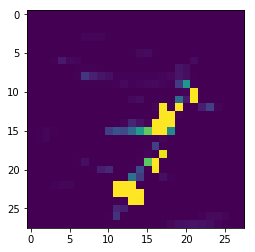

0
[408.44797  194.80858  310.7335   146.04817  127.33147  162.77567
 178.85161   57.447487 135.01839   89.17417 ]


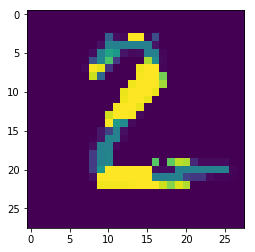

0
[116.538055 114.6782   109.606995  52.11383   65.295975 111.42443
 107.98172   58.30766   89.03258   51.88593 ]


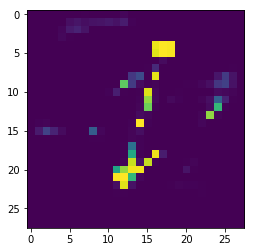

3
[182.91116 158.33899 181.53796 190.78682 160.18974 182.5262  104.62364
 108.12292 140.73701 148.71857]


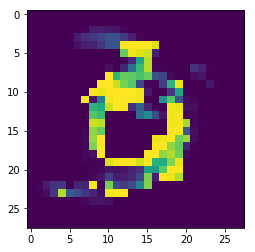

3
[105.85966 131.06248 115.66603 131.3072   81.00511 114.69106  69.55408
  76.31553  84.34196  80.41032]


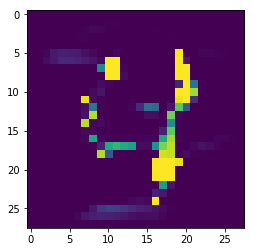

0
[186.69635  110.00974   82.79727   44.712185  47.732697 171.14705
  81.64854  174.62006   88.88178  124.67967 ]


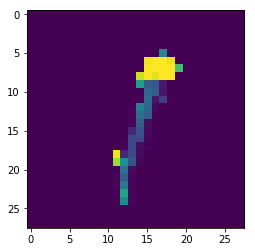

1
[ 95.735374 311.0508    86.22961  107.98695  128.74937  135.72746
  80.20592   69.74209  154.46397  124.550285]


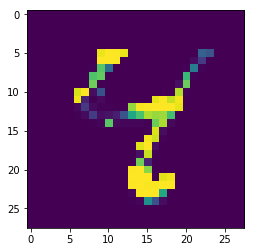

6
[104.5201  118.77514 111.26214  74.91081 191.48822 112.94117 234.9648
  95.43424 115.73194 140.14401]


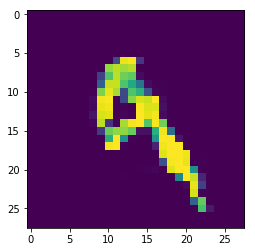

8
[217.08566  228.20026  182.88614  126.59932  175.56352  228.41786
 168.32204  123.627464 250.50786  219.7716  ]


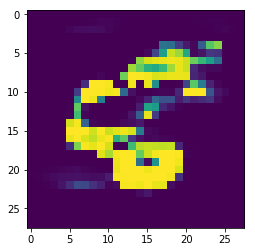

3
[133.24449 184.43776 150.23875 221.482   182.6064  205.60707 102.10431
 125.47432 142.59258 168.09882]


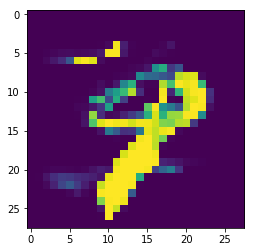

In [84]:
ph = tf.placeholder(tf.float32, [10, 28, 28, 1])
y_pred = sess.run(hingenet.get_output(ph), feed_dict={ph: adv[:10]})

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

---
# Softmax

In [8]:
from hinge_net import HingeNet

hingenet = HingeNet("softmax_xent", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/softmax_xent.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [10]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [11]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.994, 0.02220070557296276)

In [20]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 20,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:698: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  
[INFO 2018-10-19 01:16:18,614 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.989, 0.02917914819717407)
5.5127997
(0.988, 0.030205590784549714)
5.5173526
(0.982, 0.038033551067113876)
5.5130444
(0.988, 0.03250154462456703)
5.5167356
(0.99, 0.02740100508928299)
5.517961
(0.989, 0.02546709695458412)
5.51508
(0.987, 0.03418852090835571)
5.514833
(0.99, 0.024006146132946014)
5.5095525
(0.987, 0.02766333205997944)
5.5099764
(0.986, 0.03394990584254265)
5.5109797
1.0
5.3750116720199586


In [19]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 20,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:698: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  
[INFO 2018-10-19 01:15:53,198 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.959, 0.3716971619129181)
4.8757
(0.959, 0.35508241748809816)
4.8770843
(0.967, 0.3465208330154419)
4.881913
(0.959, 0.37209302043914794)
4.872279
(0.967, 0.34719896030426023)
4.87426
(0.959, 0.3752886874675751)
4.8735557
(0.961, 0.3673290014266968)
4.879808
(0.963, 0.3625405387878418)
4.8724785
(0.963, 0.35487388968467715)
4.88033
(0.954, 0.36019308590888977)
4.877313
0.992
4.666007183251843


In [23]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-16 05:44:58,366 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-16 05:44:58,661 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-16 05:44:58,772 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-10-16 05:44:58,950 cleverhans]     Iteration 0 of 200: loss=287 l2=0
[DEBUG 2018-10-16 05:44:59,658 cleverhans]     Iteration 20 of 200: loss=63.5 l2=19.9
[DEBUG 2018-10-16 05:45:00,232 cleverhans]     Iteration 40 of 200: loss=36.3 l2=27.7
[DEBUG 2018-10-16 05:45:00,890 cleverhans]     Iteration 60 of 200: loss=29.7 l2=22
[DEBUG 2018-10-16 05:45:01,604 cleverhans]     Iteration 80 of 200: loss=23.2 l2=19.1
[DEBUG 2018-10-16 05:45:02,268 cleverhans]     Iteration 100 of 200: loss=18.4 l2=17.9
[DEBUG 2018-10-16 05:45:02,875 cleverhans]     Iteration 120 of 200: loss=16.8 l2=16.6
[DEBUG 2018-10-16 05:45:03,443 cleverhans]     Iteration 140 of 200: loss=15.7 l2=15.6
[DEBUG 2018-10-16 05:45:03,986 cleverhans]     Iteration 160 of 200:

0
[ 2.80203199 -2.48919153 -0.37078318 -0.76685381 -2.36095452  0.02408018
  1.92961085  1.54772115 -1.86580324 -1.34535742]


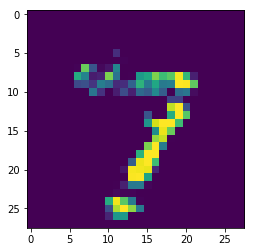

9
[-1.94009912 -2.02240658  0.99814385  4.82113218 -2.108881   -2.83310533
 -4.9489522  -6.00753784 -0.65714163  8.26577759]


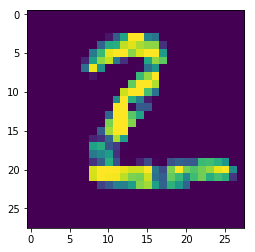

3
[-8.1391058   1.97780526 -2.44096732  5.54960442 -0.22261724 -2.51723433
 -5.14873409 -1.6671648  -5.05726719 -0.37183636]


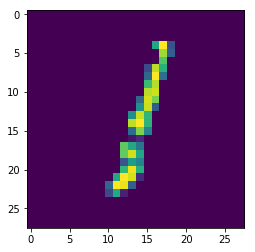

3
[ -1.14616811  -1.6730665   -1.63324058   8.17287159 -11.0246172
   1.67860401  -6.22862482  -5.29018116  -7.58714151  -3.35381603]


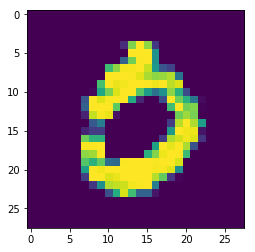

4
[-12.05783558  -3.94586802 -11.19498062  -2.0699625   10.12806702
   7.77044582  -1.04567564  -7.12609196  -6.92826462   6.70314121]


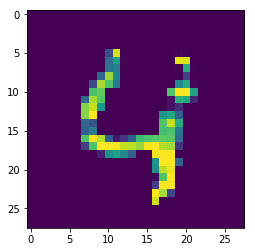

1
[-6.13241911  4.39015484 -2.96419835  2.88440704  0.16069871 -3.75466299
 -6.48991442  3.1201632  -1.28167009 -1.35591602]


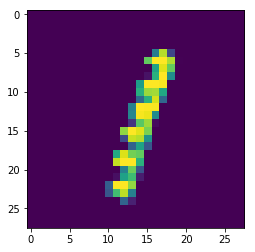

8
[ 0.08218396 -2.02466702 -0.63472944 -1.39746571  2.82215142 -3.48923874
 -0.20452635  0.28480756  3.54141688  1.87702692]


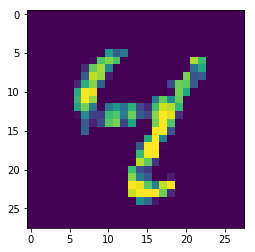

5
[-8.56877708 -3.33608007 -6.09462309 -0.94806856  3.90454769  3.97146916
  0.3220225  -6.02921915 -0.34353581  2.56948137]


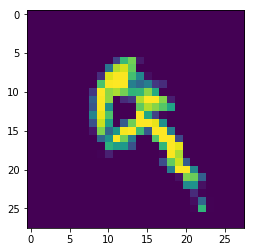

2
[-0.53026205 -2.44491673  1.54147375  1.41973472 -2.59883595  1.43202102
  0.0952283   0.31843588 -1.75519371 -0.72460938]


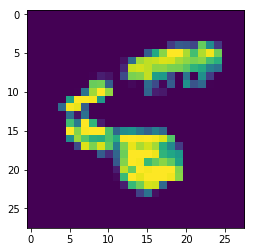

8
[-4.47075033  2.96596313 -7.1917181  -1.40604222  1.61780167 -0.65071023
 -1.10156453  1.86056519  4.47179699  3.41165781]


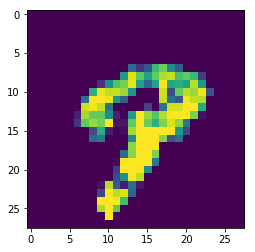

In [24]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

In [9]:
K.clear_session()
del hingenet.model
del hingenet

In [10]:
tf.global_variables()

[]

In [11]:
import gc
gc.collect()

6322